# Описание проекта

Компания разрабатывает развлекательное мобильное приложение. Несмотря на большие вложения в рекламу, последние несколько месяцев приложение является убыточным. Доступны данные за период 01.05.2019 - 27.20.2019 с пользовательскими сессиями, статистика заказов и рекламные расходы. Компания хочет понять причины убытков и способы оптимизации рекламной кампании. В ходе исследования необходимо изучить:
- откуда приходят пользователи и какими устройствами они пользуются;
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент;
- когда расходы на привлечение клиента окупаются;
- какие факторы мешают привлечению клиентов.

**Цель исследования:** обозначить причины неэффективности привлечения пользователей и дать рекомендации по оптимизации рекламной кампании.

Содержание:
1. [Загрузка данных и подготовка к анализу](#1);
2. [Определение функций для расчета и анализа LTV, ROI, удержания и конверсии](#2);
3. [Исследовательский анализ данных](#3);
4. [Анализ маркетинга](#4);
5. [Анализ окупаемиости рекламы](#5);
6. [Итоговые выводы](#6).

## Загрузка данных и подготовка к анализу
<a id='1'></a>

In [1]:
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

In [2]:
# загружаем датасет с пользовательскими сессиями
sessions = pd.read_csv('visits_info_short.csv')
sessions.columns = sessions.columns.str.lower()
sessions = sessions.rename(columns={
    'user id': 'user_id', 
    'session start': 'session_start', 
    'session end': 'session_end'})
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
sessions['session_end'] = pd.to_datetime(sessions['session_end'])
display(sessions.head())

# загружаем датасет с заказами
orders = pd.read_csv('orders_info_short.csv')
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={
    'user id': 'user_id',
    'event dt': 'event_dt'})
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
display(orders.head())

# загружаем датасет с затратами на рекламу 
costs = pd.read_csv('costs_info_short.csv')
costs.columns = costs.columns.str.lower()
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
display(costs.head())

user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic 2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop 2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic 2019-05-01 03:33:35   

          session_end  
0 2019-05-01 02:45:01  
1 2019-05-01 04:47:35  
2 2019-05-01 15:32:08  
3 2019-05-01 00:54:25  
4 2019-05-01 03:57:40

user_id            event_dt  revenue
0  188246423999 2019-05-01 23:09:52     4.99
1  174361394180 2019-05-01 12:24:04     4.99
2  529610067795 2019-05-01 11:34:04     4.99
3  319939546352 2019-05-01 15:34:40     4.99
4  366000285810 2019-05-01 13:59:51     4.99

dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [3]:
# проверка на наличие дубликатов
for i in [sessions, orders, costs]:
    print(i.duplicated().sum())

0
0
0


In [4]:
# Выведем информацию о количестве пропусков
for i in [sessions, orders, costs]:
    display(pd.DataFrame(round((i.isna().mean()*100),2), columns=['NaNs, %']).style.format(
    '{:.2f}').background_gradient('coolwarm'))

**Вывод**: данные подготовлены для дальнейшего анализа, пропуски и дубликаты отсутствуют.

## Определение функций для расчета и анализа LTV, ROI, удержания и конверсии
<a id='2'></a>

In [5]:
# функция для создания пользовательских профилей
events = None  # других событий нет, None — чтобы не «сломать» get_profiles()
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [6]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [7]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [8]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [9]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [10]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [11]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [12]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных
<a id='3'></a>

In [13]:
# получаем профили пользователей
profiles = get_profiles(sessions, orders, events, costs)
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

In [14]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

In [15]:
min_analysis_date = profiles['dt'].min() # минимальная дата привлечения
max_analysis_date = profiles['dt'].max() # максимальная дата привлечения
print(min_analysis_date)
print(max_analysis_date)

2019-05-01
2019-10-27


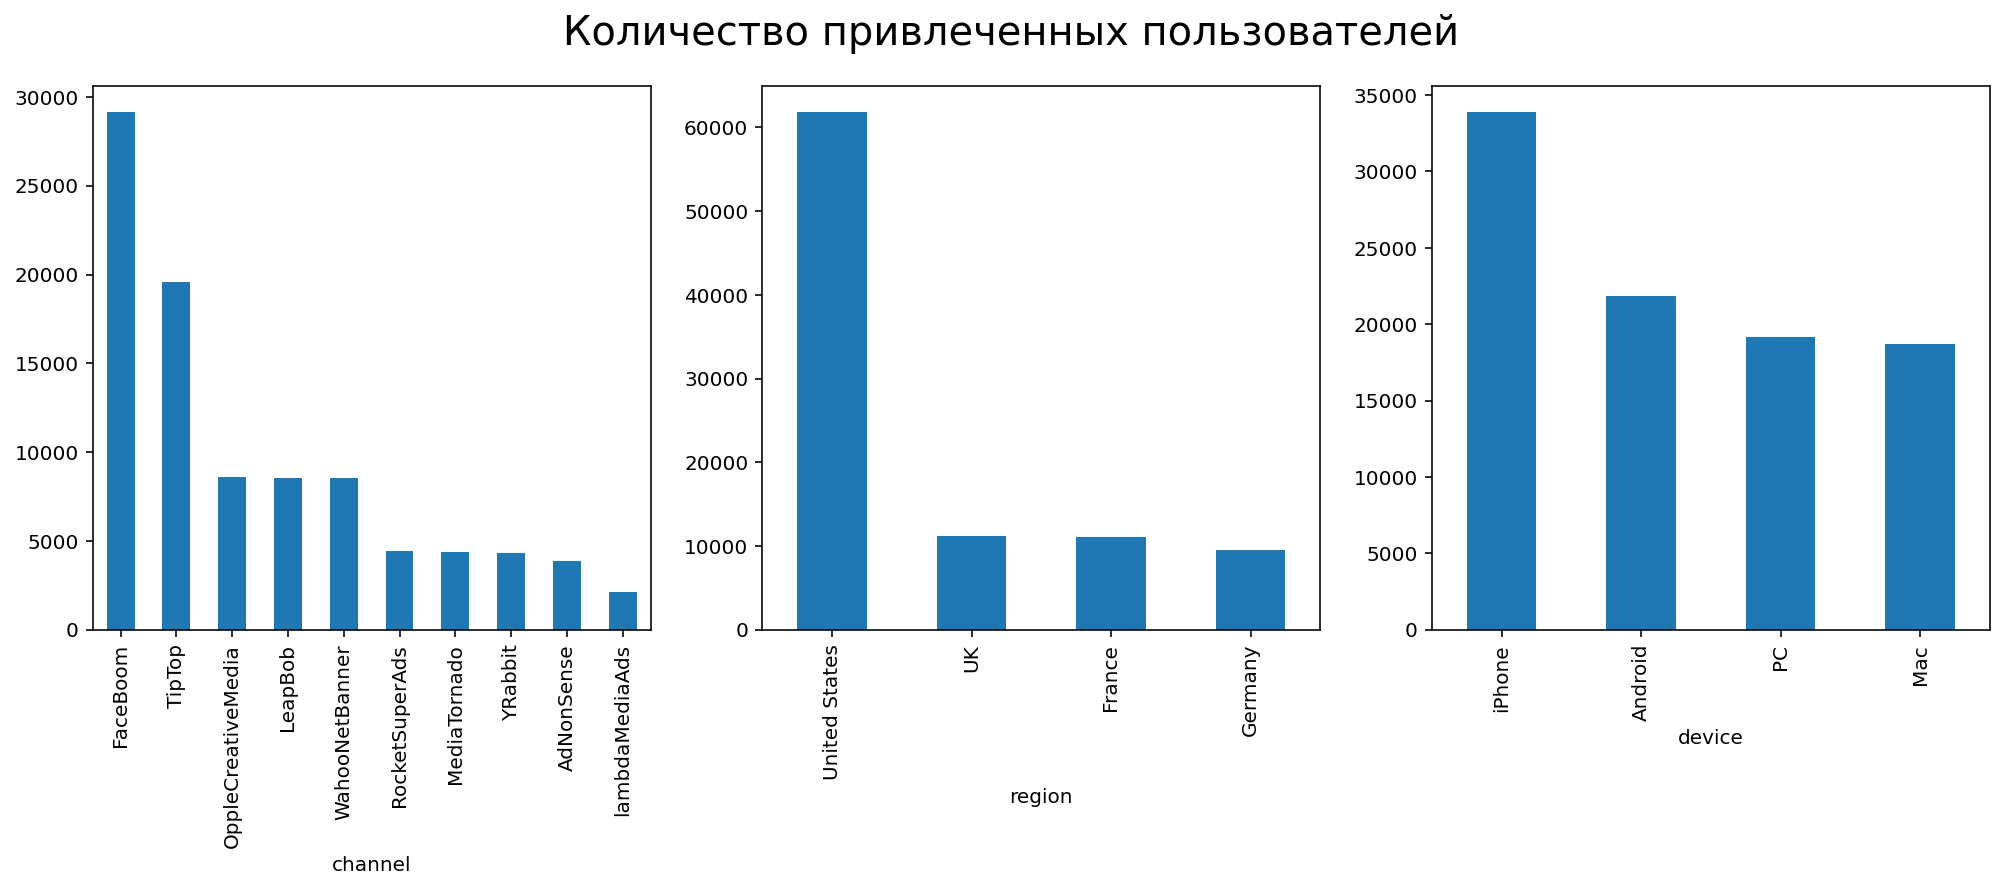

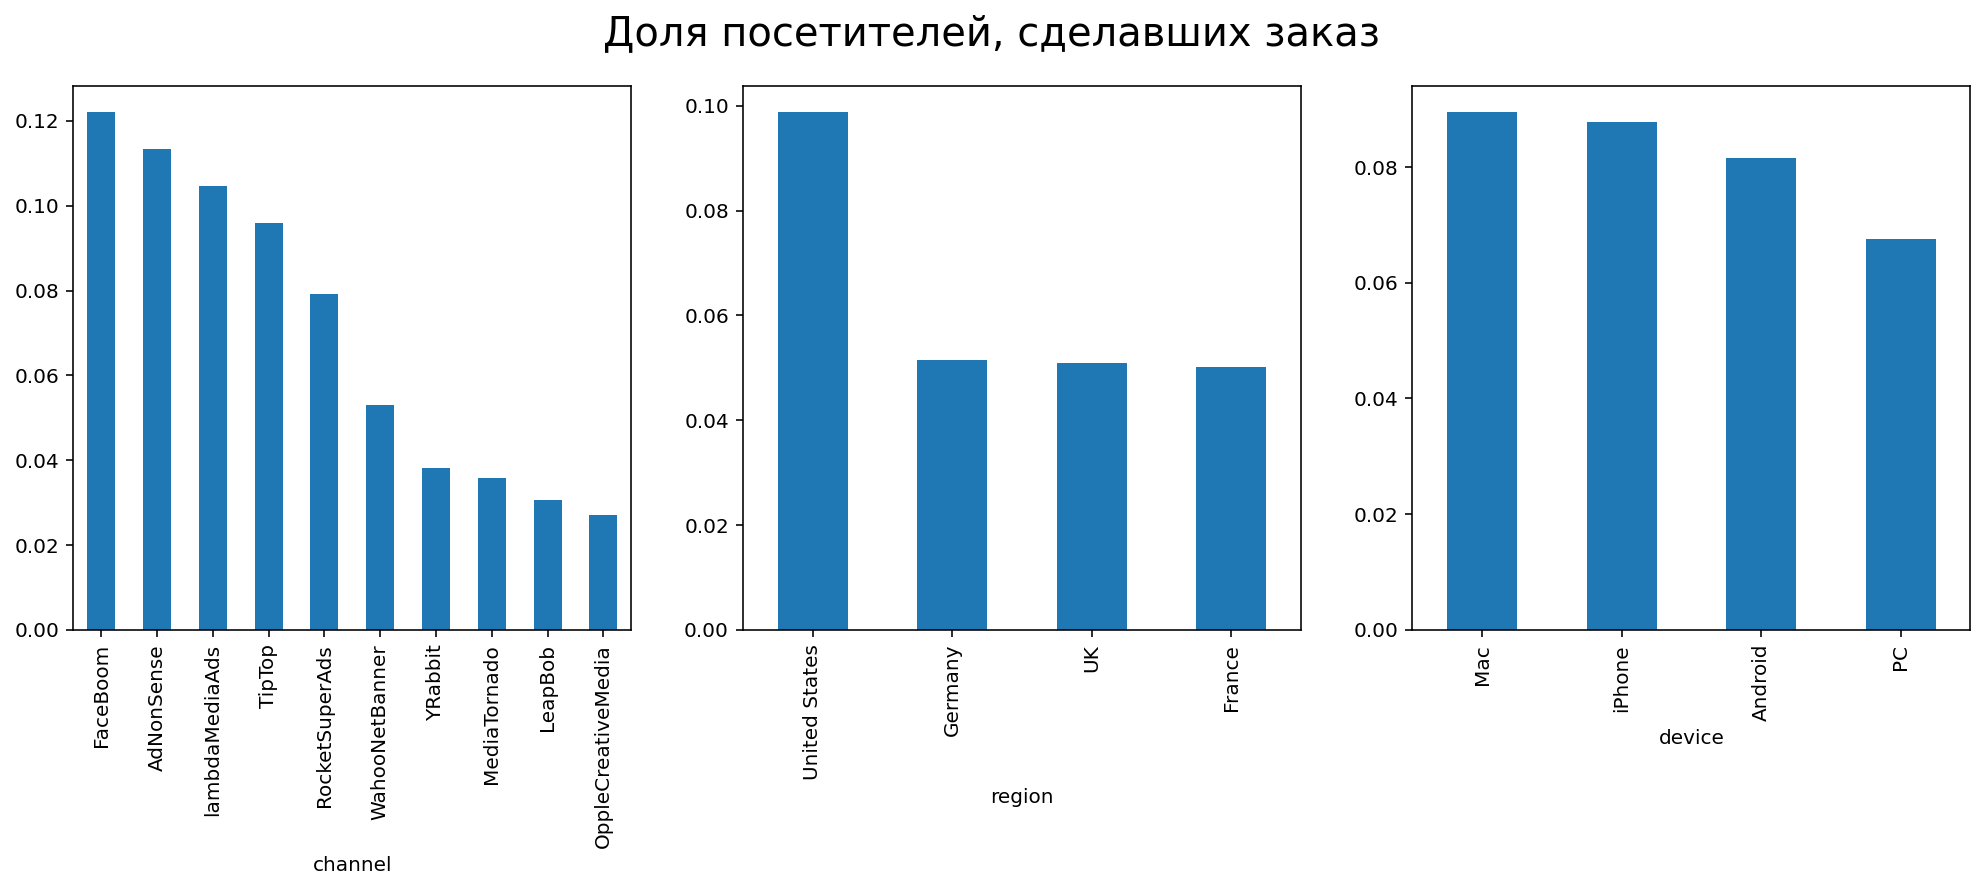

In [38]:
# строим диаграммы кол-ва пользователей и долей платящих ползователей

fig, axes = plt.subplots(1,3, figsize=(17,5))
fig.suptitle('Количество привлеченных пользователей', fontsize=20)

for i, dimension in enumerate(['channel', 'region', 'device']):
    (profiles.groupby(dimension).agg({'user_id': 'nunique'})
     .sort_values(by='user_id', ascending=False)
     .plot(kind='bar', legend=False, ax=axes[i]))
plt.show()

fig, axes = plt.subplots(1,3, figsize=(17,5))
fig.suptitle('Доля посетителей, сделавших заказ', fontsize=20)

for i, dimension in enumerate(['channel', 'region', 'device']):
    (profiles.groupby(dimension).agg({'payer': 'mean'})
     .sort_values(by='payer', ascending=False)
     .plot(kind='bar', legend=False, ax=axes[i]))
plt.show()

In [17]:
(
    profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'})
 .sort_values(by='payer', ascending=False).rename(columns={'user_id': 'Количество пользователей', 
                                                           'payer': 'Доля платящих'})

)

Количество пользователей  Доля платящих
region                                                
United States                    100002       0.069019
Germany                           14981       0.041119
UK                                17575       0.039829
France                            17450       0.037994

In [18]:
(
    profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'})
 .sort_values(by='payer', ascending=False).rename(columns={'user_id': 'Количество пользователей', 
                                                           'payer': 'Доля платящих'})

)

Количество пользователей  Доля платящих
device                                          
Mac                         30042       0.063644
iPhone                      54479       0.062079
Android                     35032       0.058518
PC                          30455       0.050468

In [19]:
(
    profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'})
 .sort_values(by='payer', ascending=False).rename(columns={'user_id': 'Количество пользователей', 
                                                           'payer': 'Доля платящих'})

)

Количество пользователей  Доля платящих
channel                                                    
FaceBoom                               29144       0.122049
AdNonSense                              3880       0.113402
lambdaMediaAds                          2149       0.104700
TipTop                                 19561       0.096007
RocketSuperAds                          4448       0.079137
WahooNetBanner                          8553       0.052964
YRabbit                                 4312       0.038265
MediaTornado                            4364       0.035747
LeapBob                                 8553       0.030633
OppleCreativeMedia                      8605       0.027077
organic                                56439       0.020553

**Выводы**:
- Пользователи приходят в приложение из 4 стран. Количество пользователей из США в несколько раз превышает кол-во пользователей из других стран. Также США являются лидером по доле пользователей, сделавших заках (7%);
- Пользователи заходят в приложение с 4 устройств, наибольшее число c iPhone. Однако по доле платящих пользователей лидерство делят Mac и iPhone (6,3% и 6,2% соответственно);
- Всего задействовано 10 рекламных каналов, наибольшее кол-во пользователей пришло из FaceBoom. Доля платящих пользователей по этому источнику также максимальная. Значительная доля пользователей пришла сама (без рекламы), однако конверсия таких пользователей в покупателей минимальна.

## Маркетинг
<a id='4'></a>

In [20]:
costs['costs'].sum() # общие расходы на маркетинг

105497.30000000002

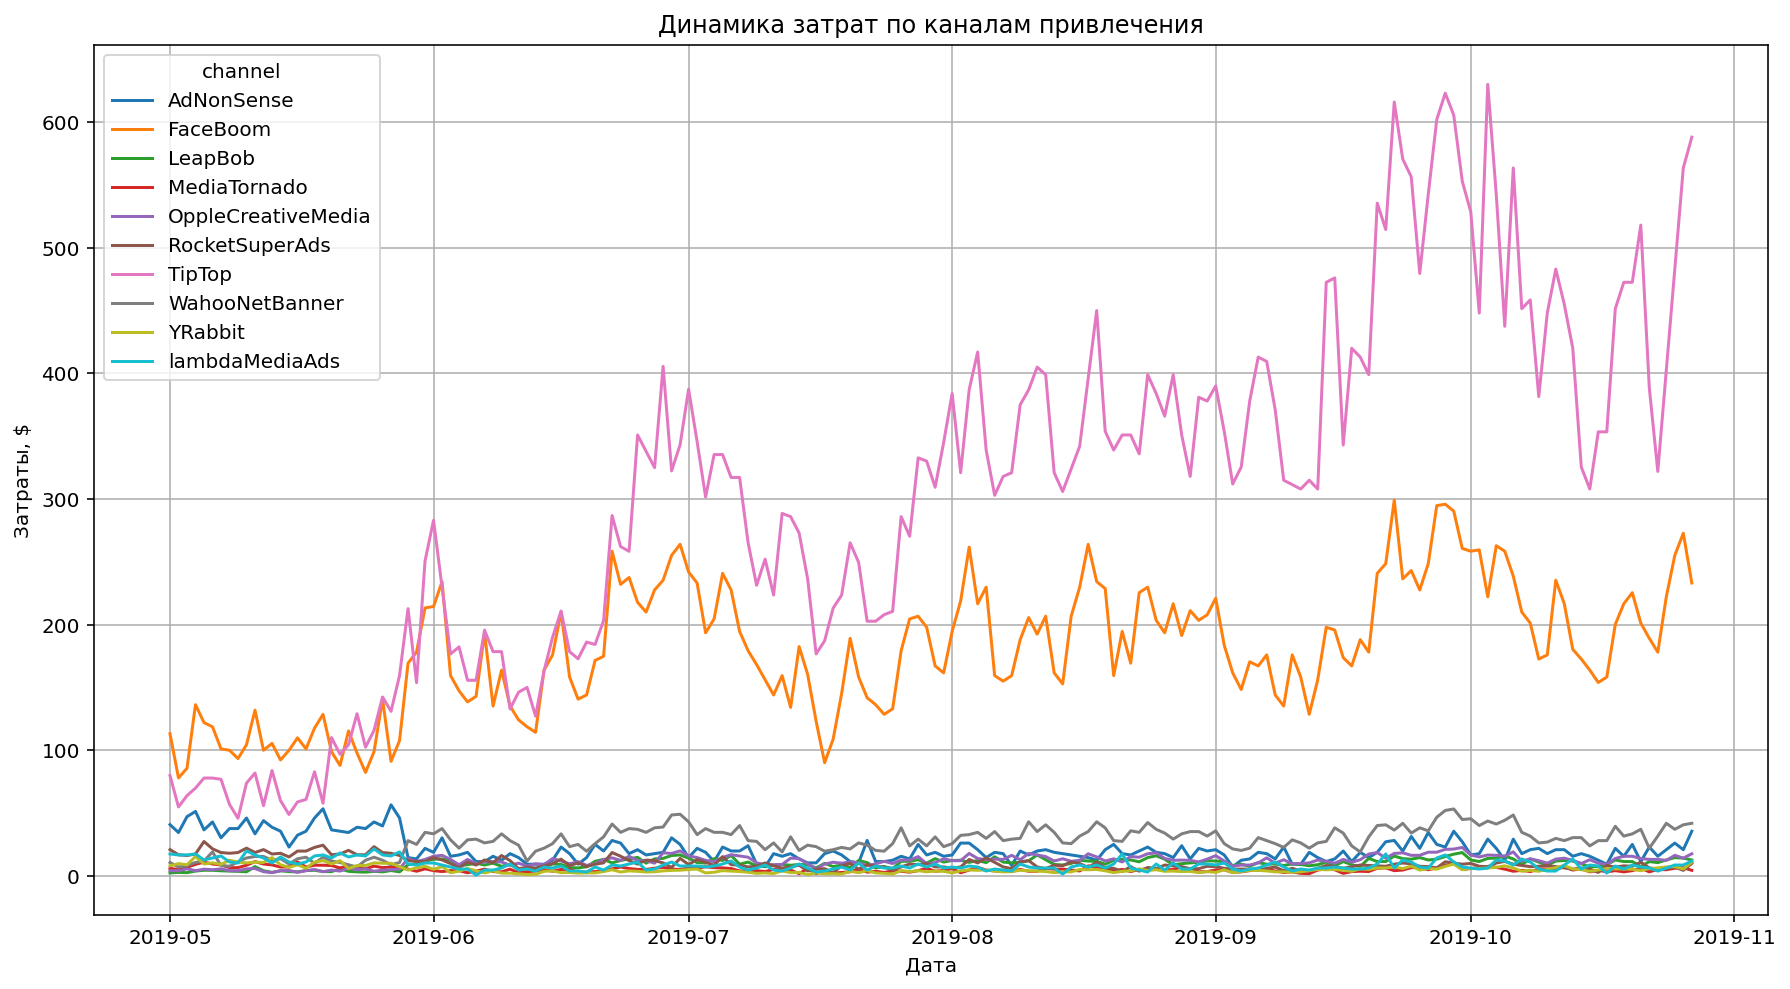

In [21]:
# график истории изменений затрат по каналам привлечения
costs.pivot_table(
    index='dt', columns='channel', values='costs', aggfunc='mean'
).plot(grid=True, figsize=(15, 8))
plt.ylabel('Затраты, $')
plt.xlabel('Дата')
plt.title('Динамика затрат по каналам привлечения')
plt.show()

In [23]:
# средний CAC на одного пользователя для всего проекта (без органики)
profiles.query('channel != "organic"')['acquisition_cost'].mean()

1.127481323942928

In [24]:
# средний CAC на одного пользователя для каждого источника трафика
(
    profiles.groupby('channel').agg({'acquisition_cost': 'mean'})
    .sort_values(by='acquisition_cost', ascending=False)
    .rename(columns={'acquisition_cost': 'Средний CAC на пользователя'})
)

Средний CAC на пользователя
channel                                        
TipTop                                 2.799003
FaceBoom                               1.113286
AdNonSense                             1.008054
lambdaMediaAds                         0.724802
WahooNetBanner                         0.602245
RocketSuperAds                         0.412095
OppleCreativeMedia                     0.250000
YRabbit                                0.218975
MediaTornado                           0.218717
LeapBob                                0.210172
organic                                0.000000

In [25]:
# распределение CAC по источникам
(profiles.groupby('channel').agg({'acquisition_cost': 'sum'})
 .sort_values(by='acquisition_cost', ascending=False)
 .rename(columns={'acquisition_cost': 'Общий CAC'})

)

Общий CAC
channel                      
TipTop               54751.30
FaceBoom             32445.60
WahooNetBanner        5151.00
AdNonSense            3911.25
OppleCreativeMedia    2151.25
RocketSuperAds        1833.00
LeapBob               1797.60
lambdaMediaAds        1557.60
MediaTornado           954.48
YRabbit                944.22
organic                  0.00

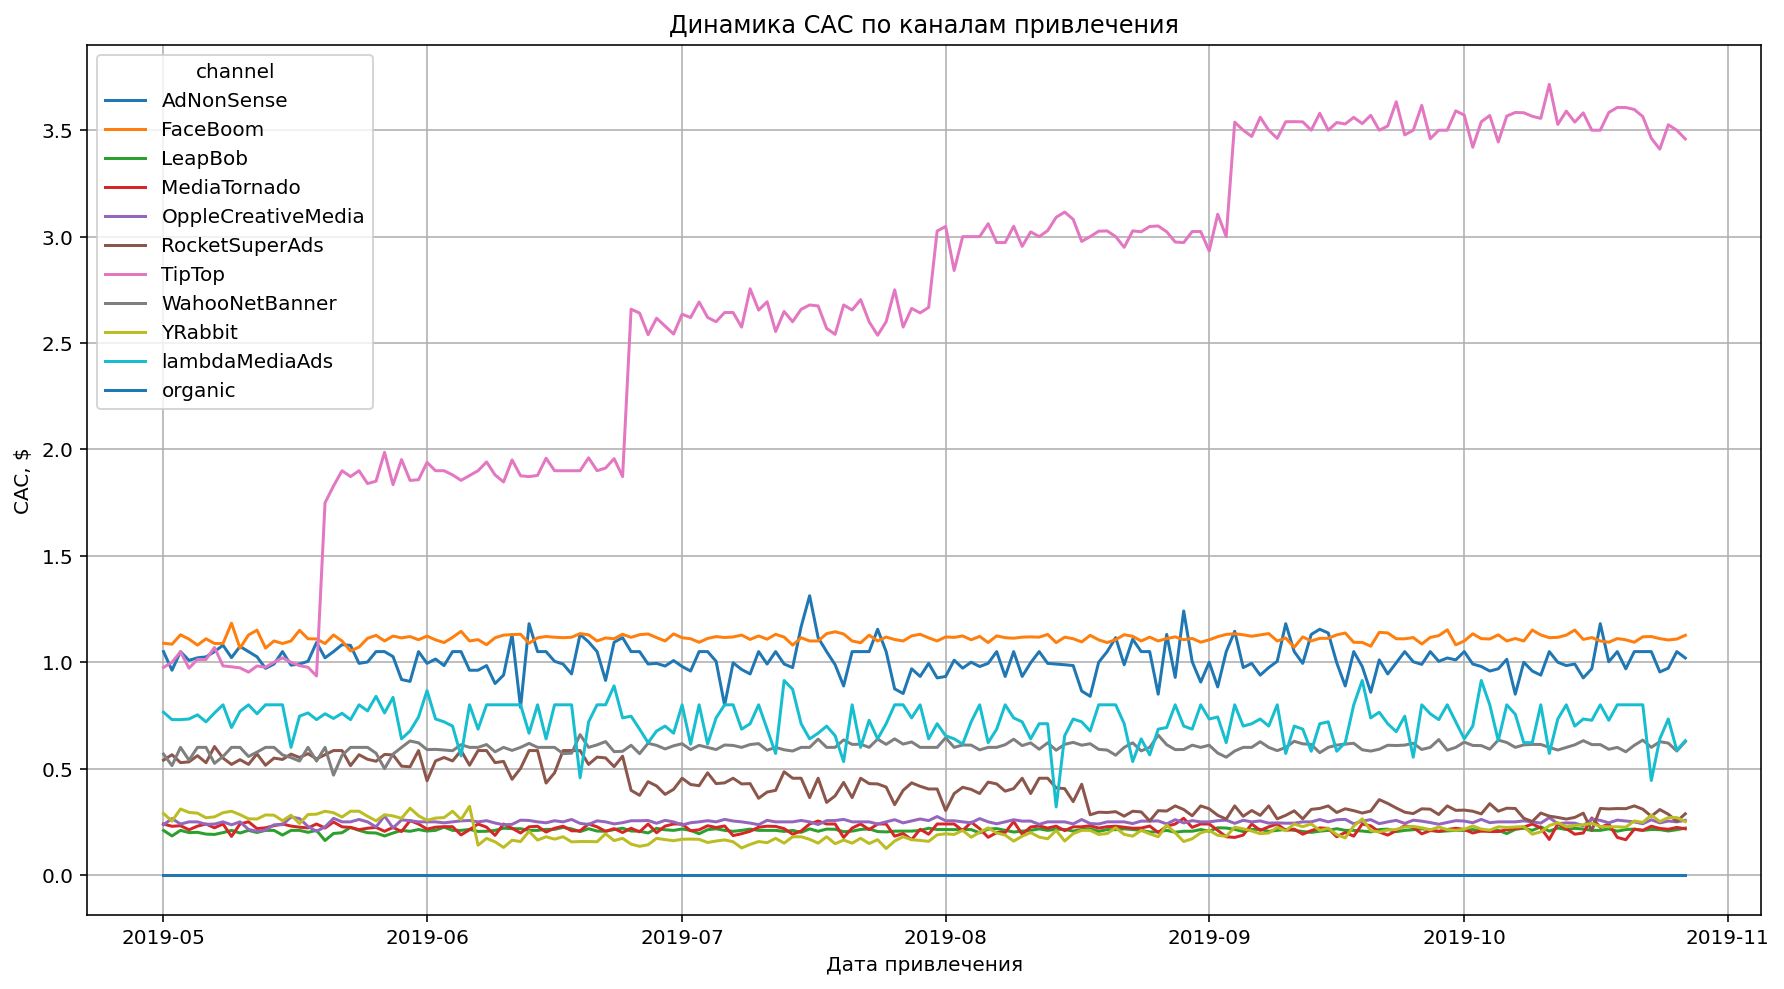

In [26]:
# график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 8))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

 **Выводы:**
 - Всего компания потратила 105497 долл. на привлечение пользователей;
 - Наибольшие затраты в первый месяц приходились на FaceBoom, однако к концу второго месяца более затратным стал TipTop - расходы расли на протяжении всего исследуемого периода;
 - Стоимость привлечения одного пользователя в целом по проекту составляет 1,13 долл.;
 - Наиболее дорогие каналы в расчете на пользователя: TipTop, FaceBoom, AdNonSense;
 - Стоимость привлечения одного пользователя по каналу TipTop растет, к концу периода достигла отметки в 3.5 долл., что намного превышает среднее значение. CAC по остальным источникам относительно стабилен.

## Окупаемость рекламы
<a id='5'></a>

In [27]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа
profiles = profiles.query('channel != "organic"') # исключаем органику

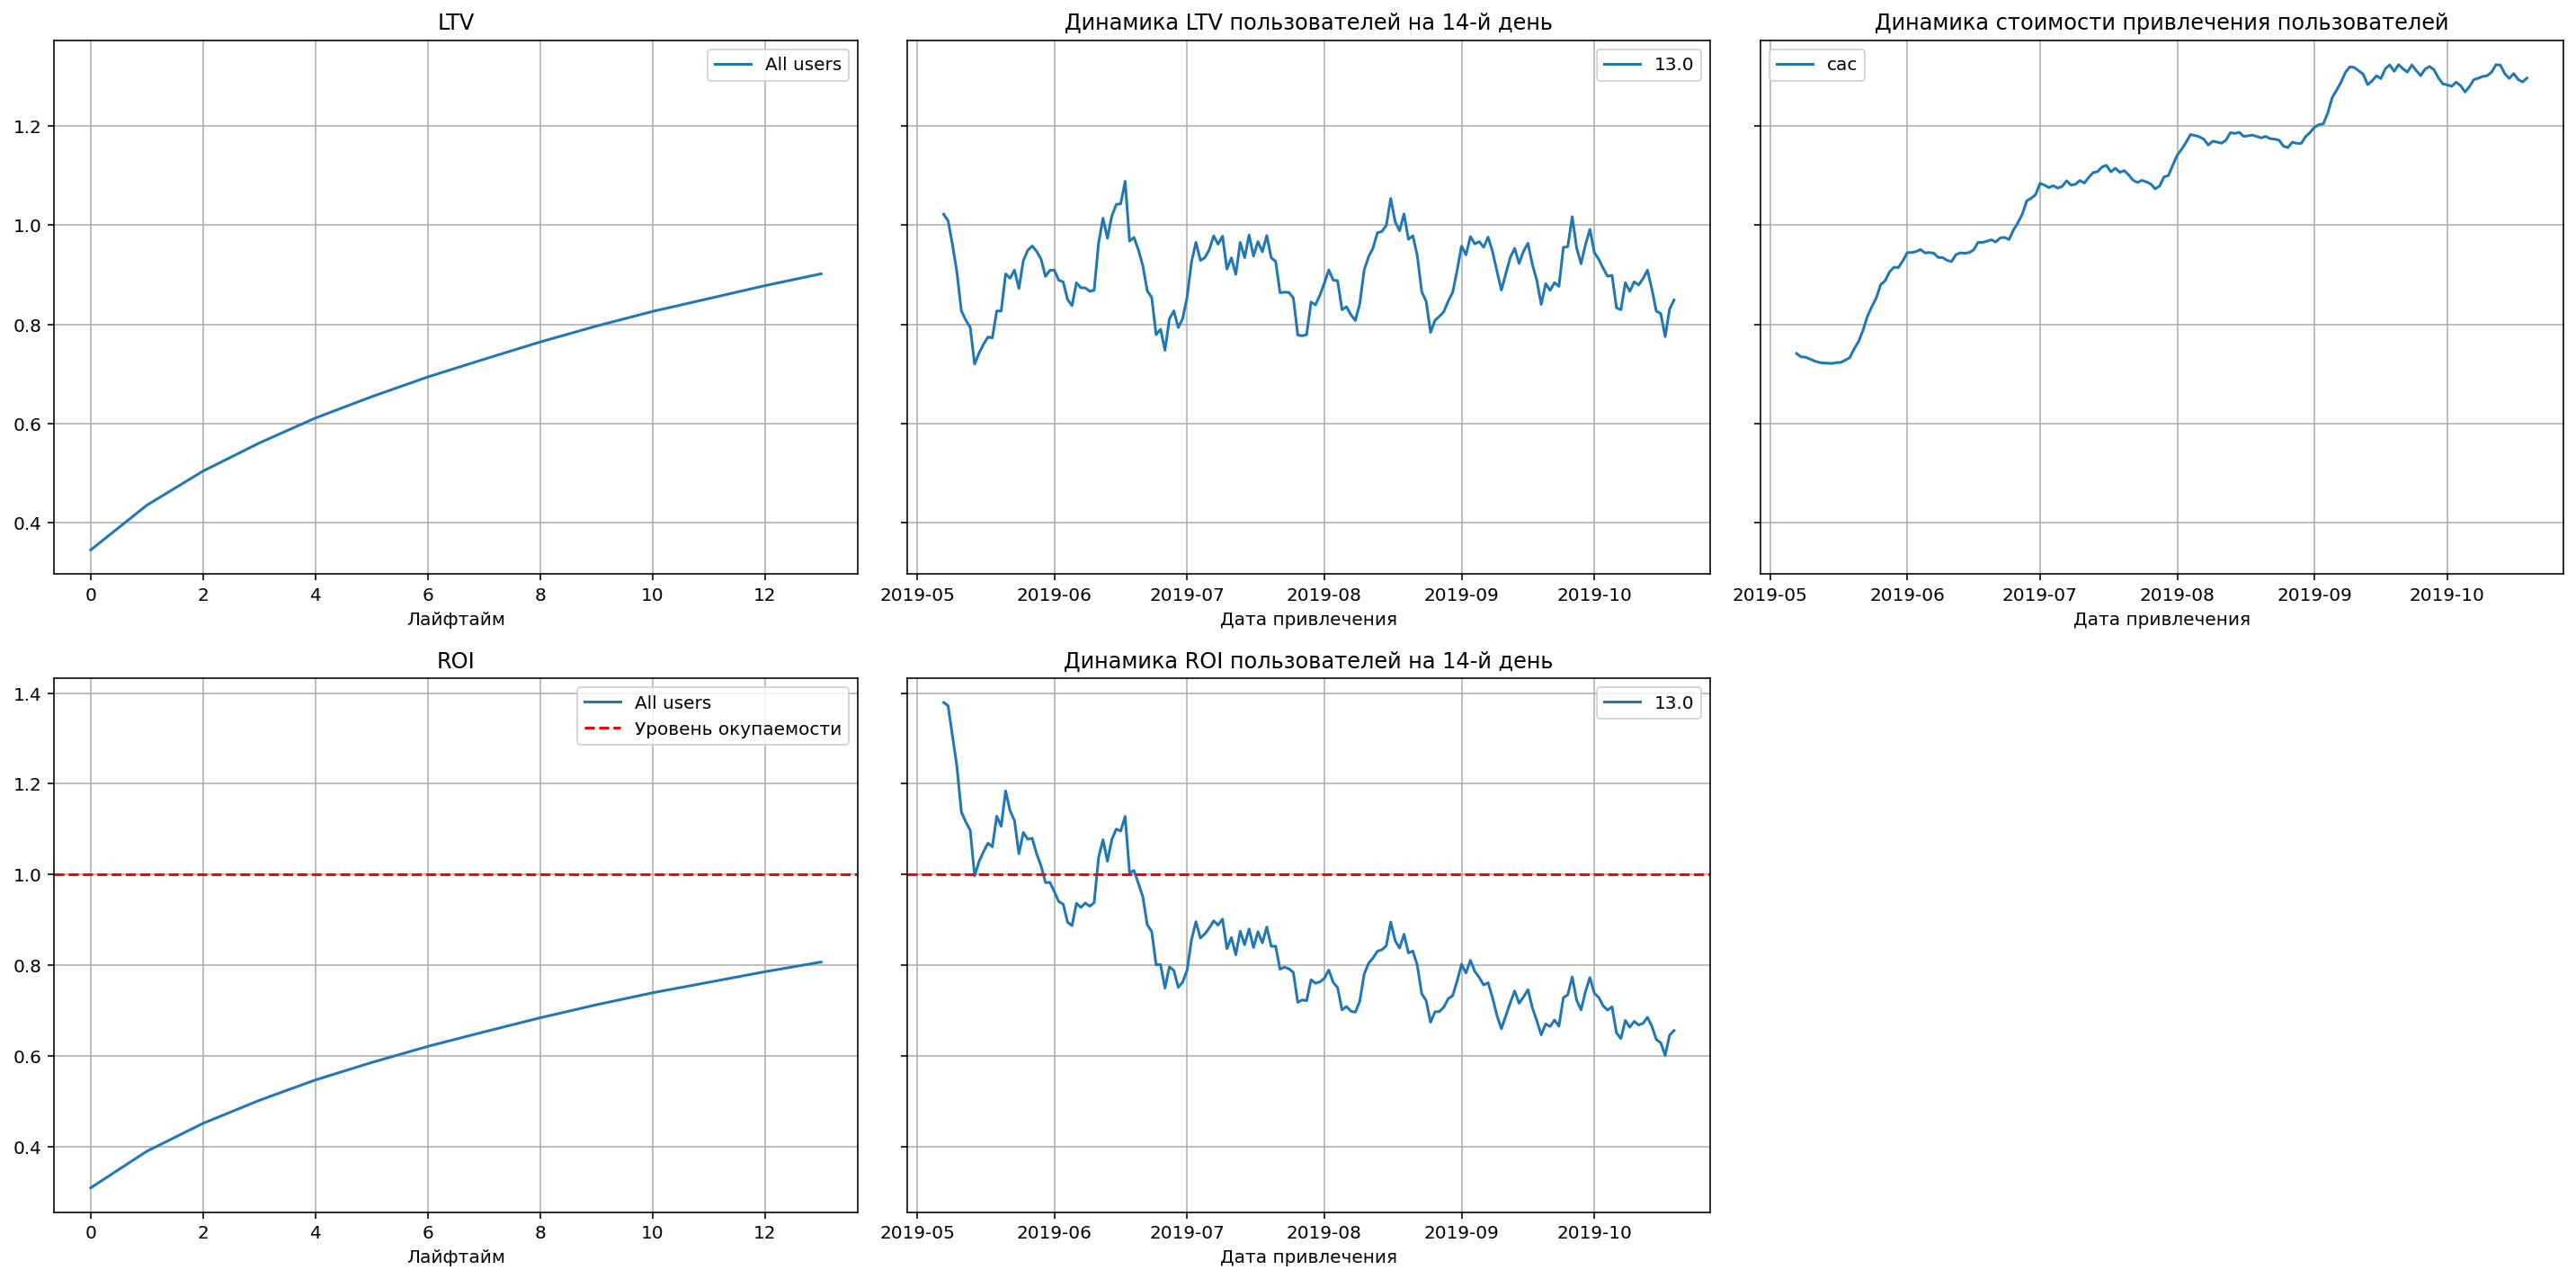

In [28]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Выводы:**
- Реклама не окупается, ROI в конце второй недели менее 1;
- CAC растет на протяжении всего периода. Как выяснили ранее, рост обусловлен увеличением затрат по каналу TipTop;
- LTV подтвержен колебаниям, но относительно стабилен;
- Реклама перестала окупаться к концу июня 2019г. Основная причина - стоимость привлечения по каналу TipTop стала слишком высокой.

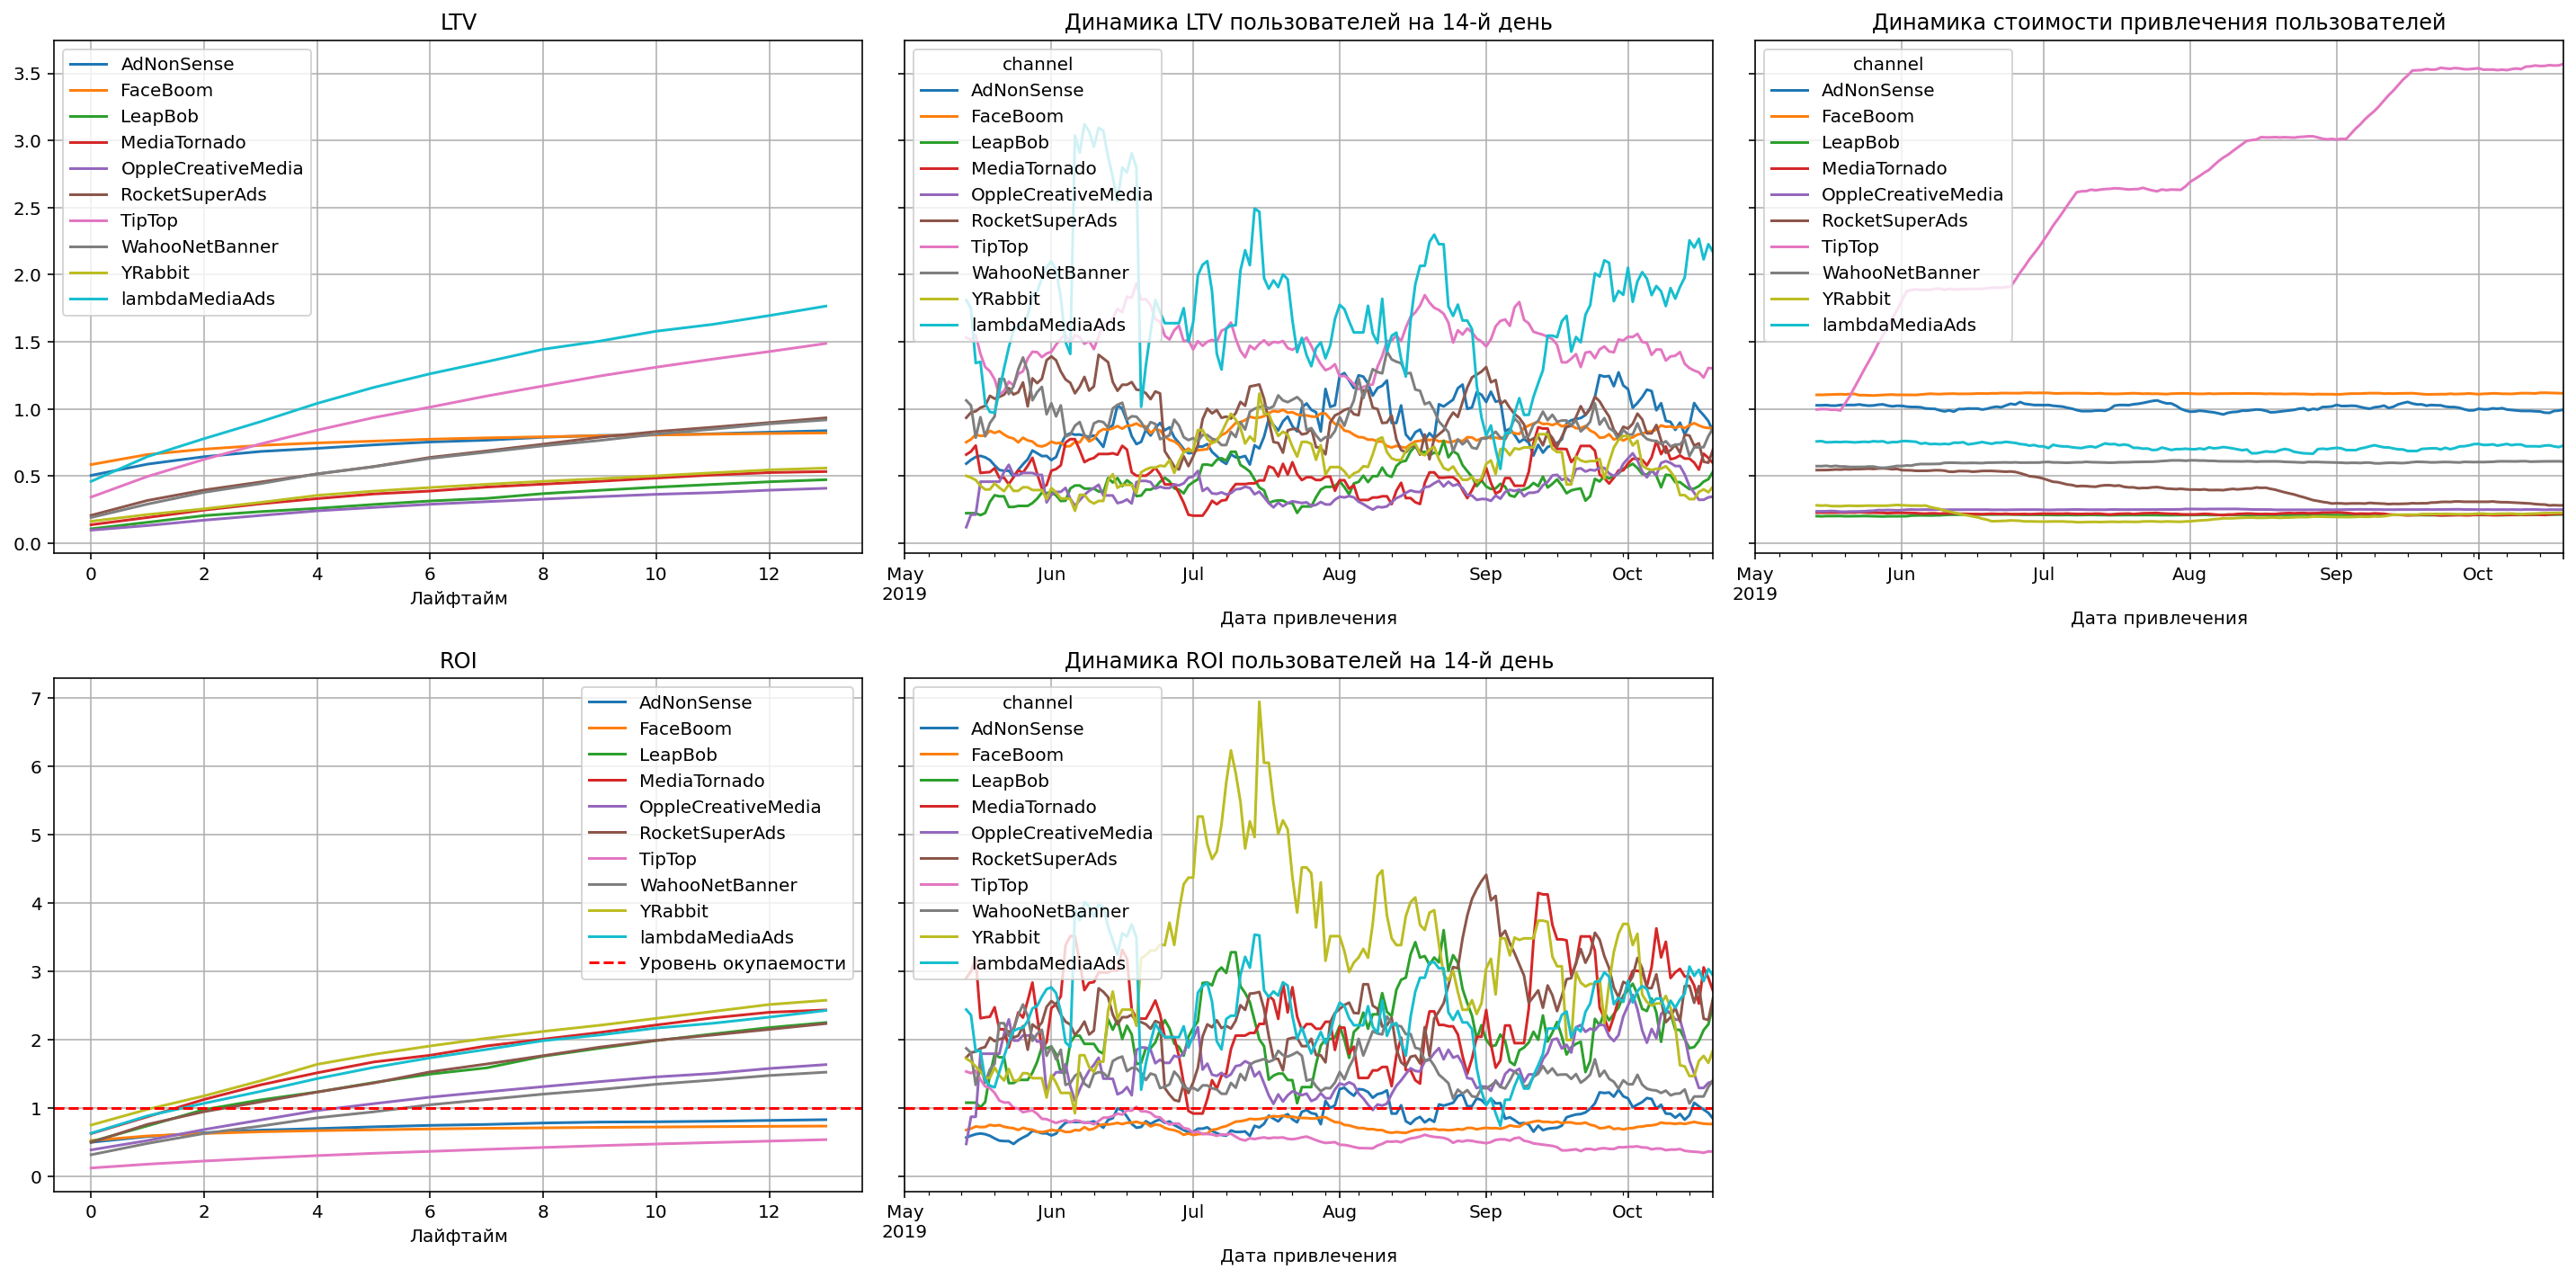

In [29]:
# посмотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Выводы**:
- Больше всего денег приносят пользователи с каналов lambdaMediaAds и TipTop, меньше всего - OppleCreativeMedia. При этом в последние два месяца LTV по TipTop снижается, а по lambdaMediaAds увеличивается;
- Несмотря на то, что упомянутые выше каналы приносят больше платящих пользователей, стоимость привлечения таких пользователей отличается в разы - 3,5 долл. у TipTop против 0,75 долл. у lambdaMediaAds;
- Пользователи с TipTop не окупаются в течение 14 дней. Также убыточными каналами являются FaceBoom и AdNonSense. Каналы с наибольшей окупаемостью: YRabbit, MediaTornado,lambdaMediaAds. Однако стоит учесть, что в последние два месяца окупаемость YRabbit снижается.

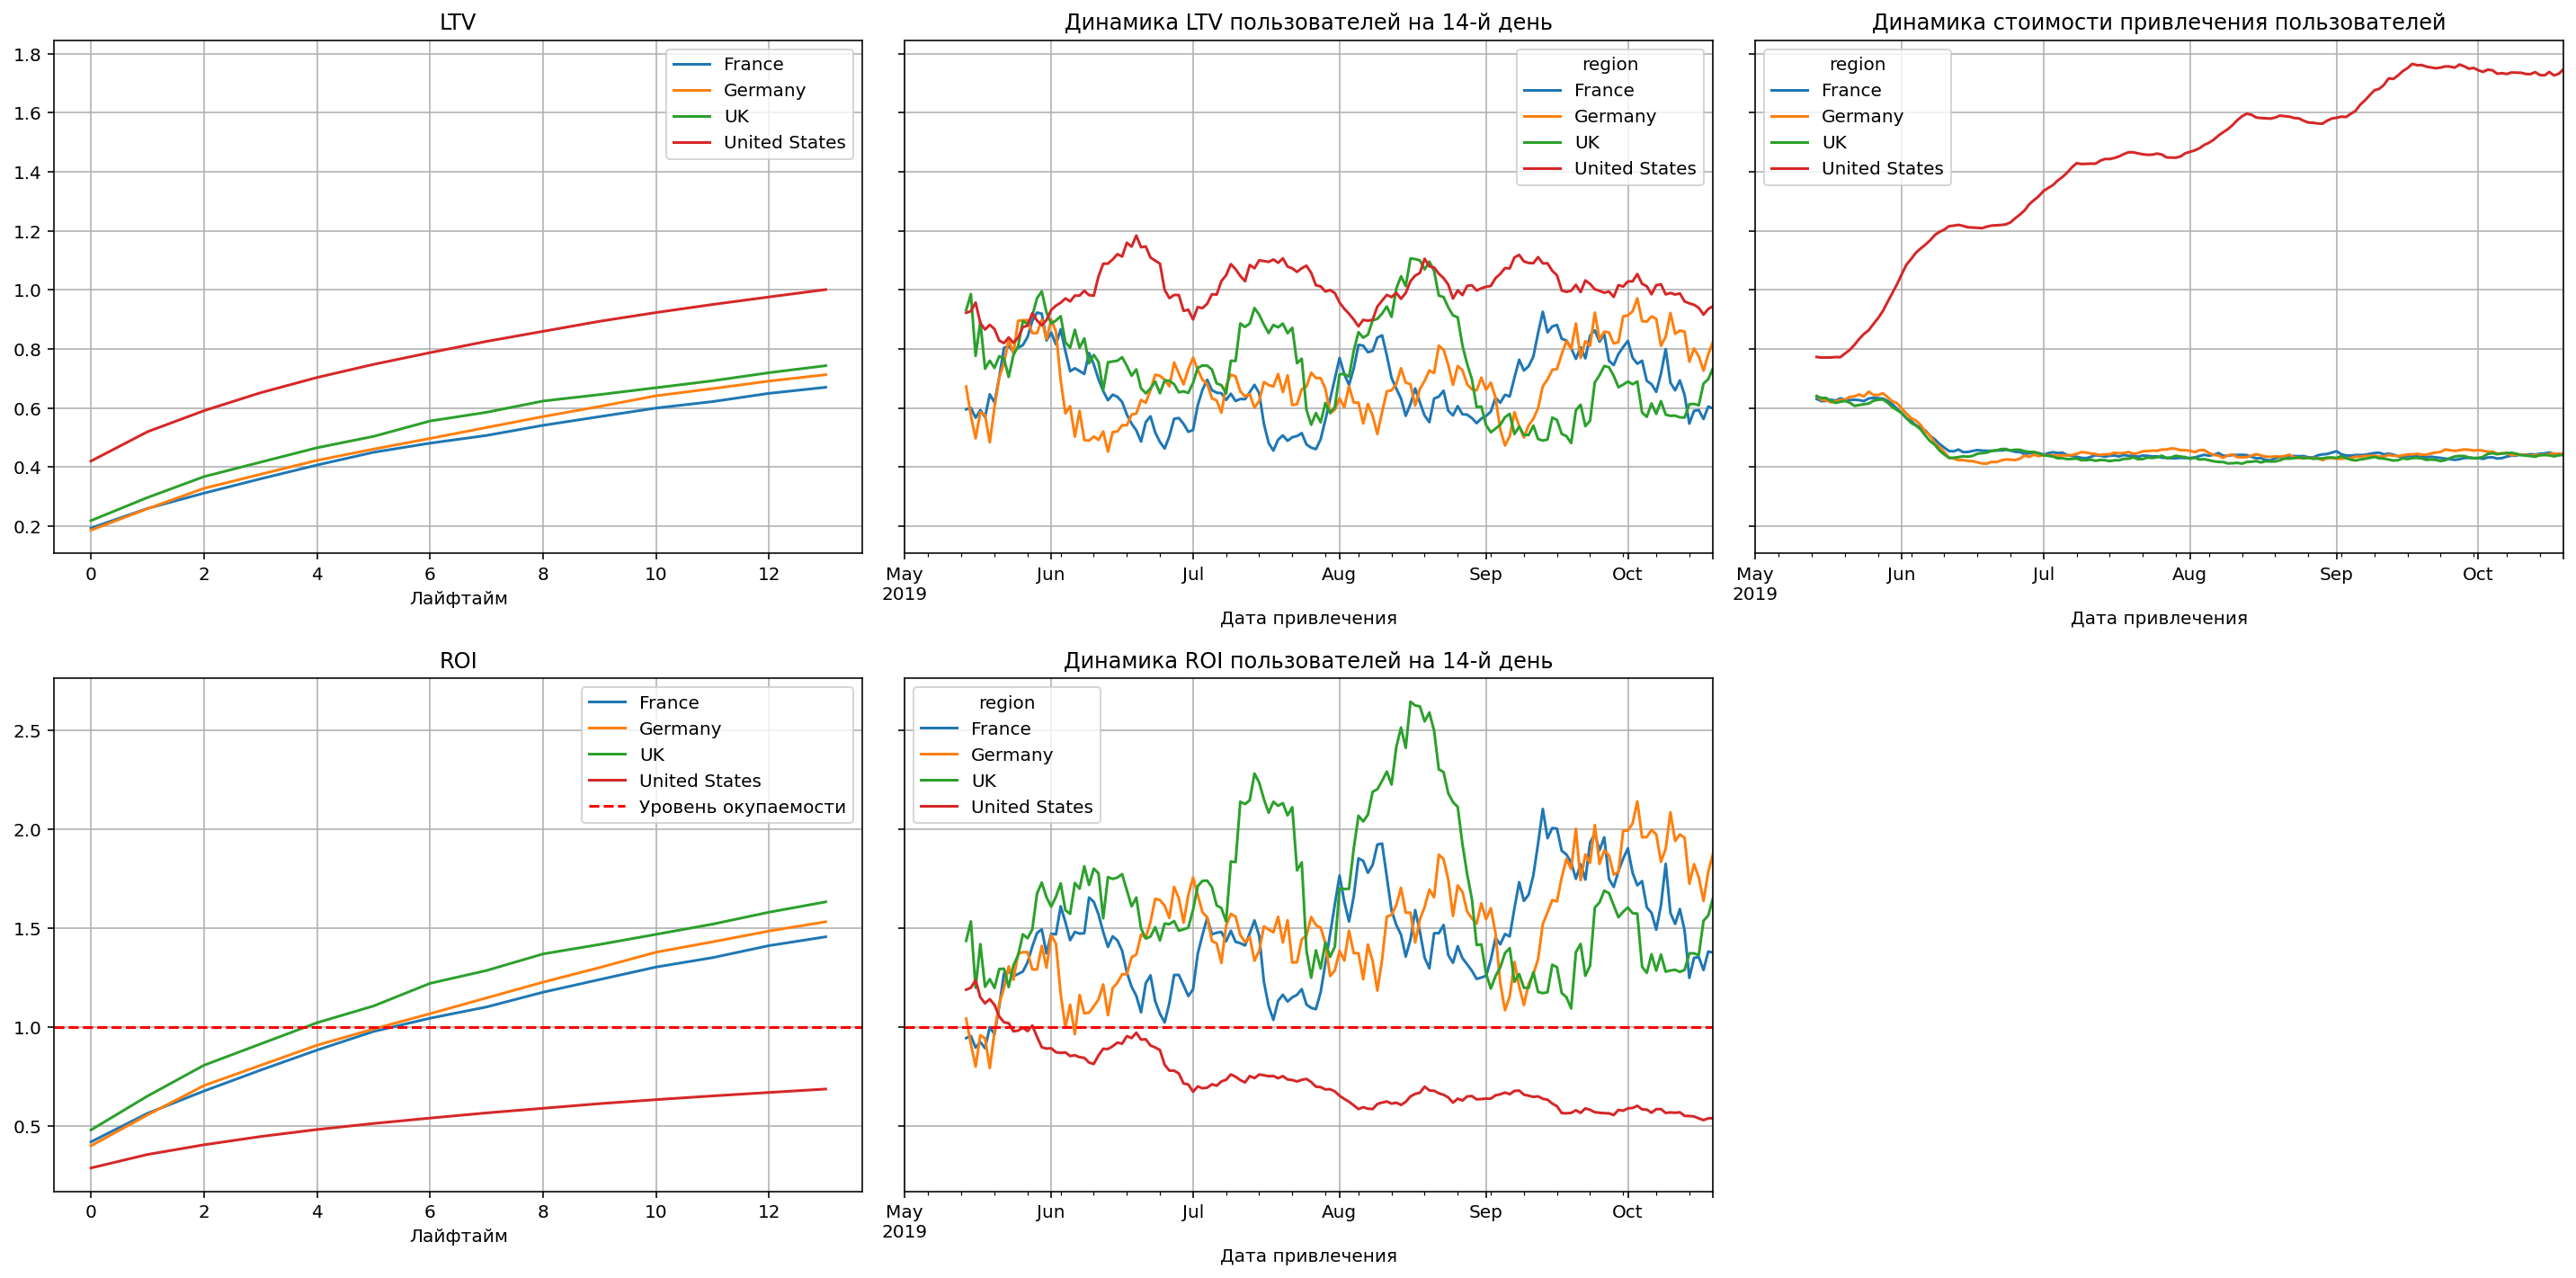

In [30]:
# посмотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

In [31]:
# разбивка по источникам из США
profiles.query('region == "United States"').groupby('channel').agg({'region': 'count'})   

region
channel               
FaceBoom         29144
MediaTornado      4364
RocketSuperAds    4448
TipTop           19561
YRabbit           4312

**Выводы:**
- Стабильно больше денег приносят пользователи из США, однако стоимость привлечения таких пользователей в разы больше, и продолжает расти. В первую очередь это связано с высокой долей убыточных каналов - TipTop и FaceBoom;
- Привлечение пользователей из США не окупается. Наиболшая окупаемость у Великобритании;
- Пользователи из США перестали окупаться с конца мая 2019г.

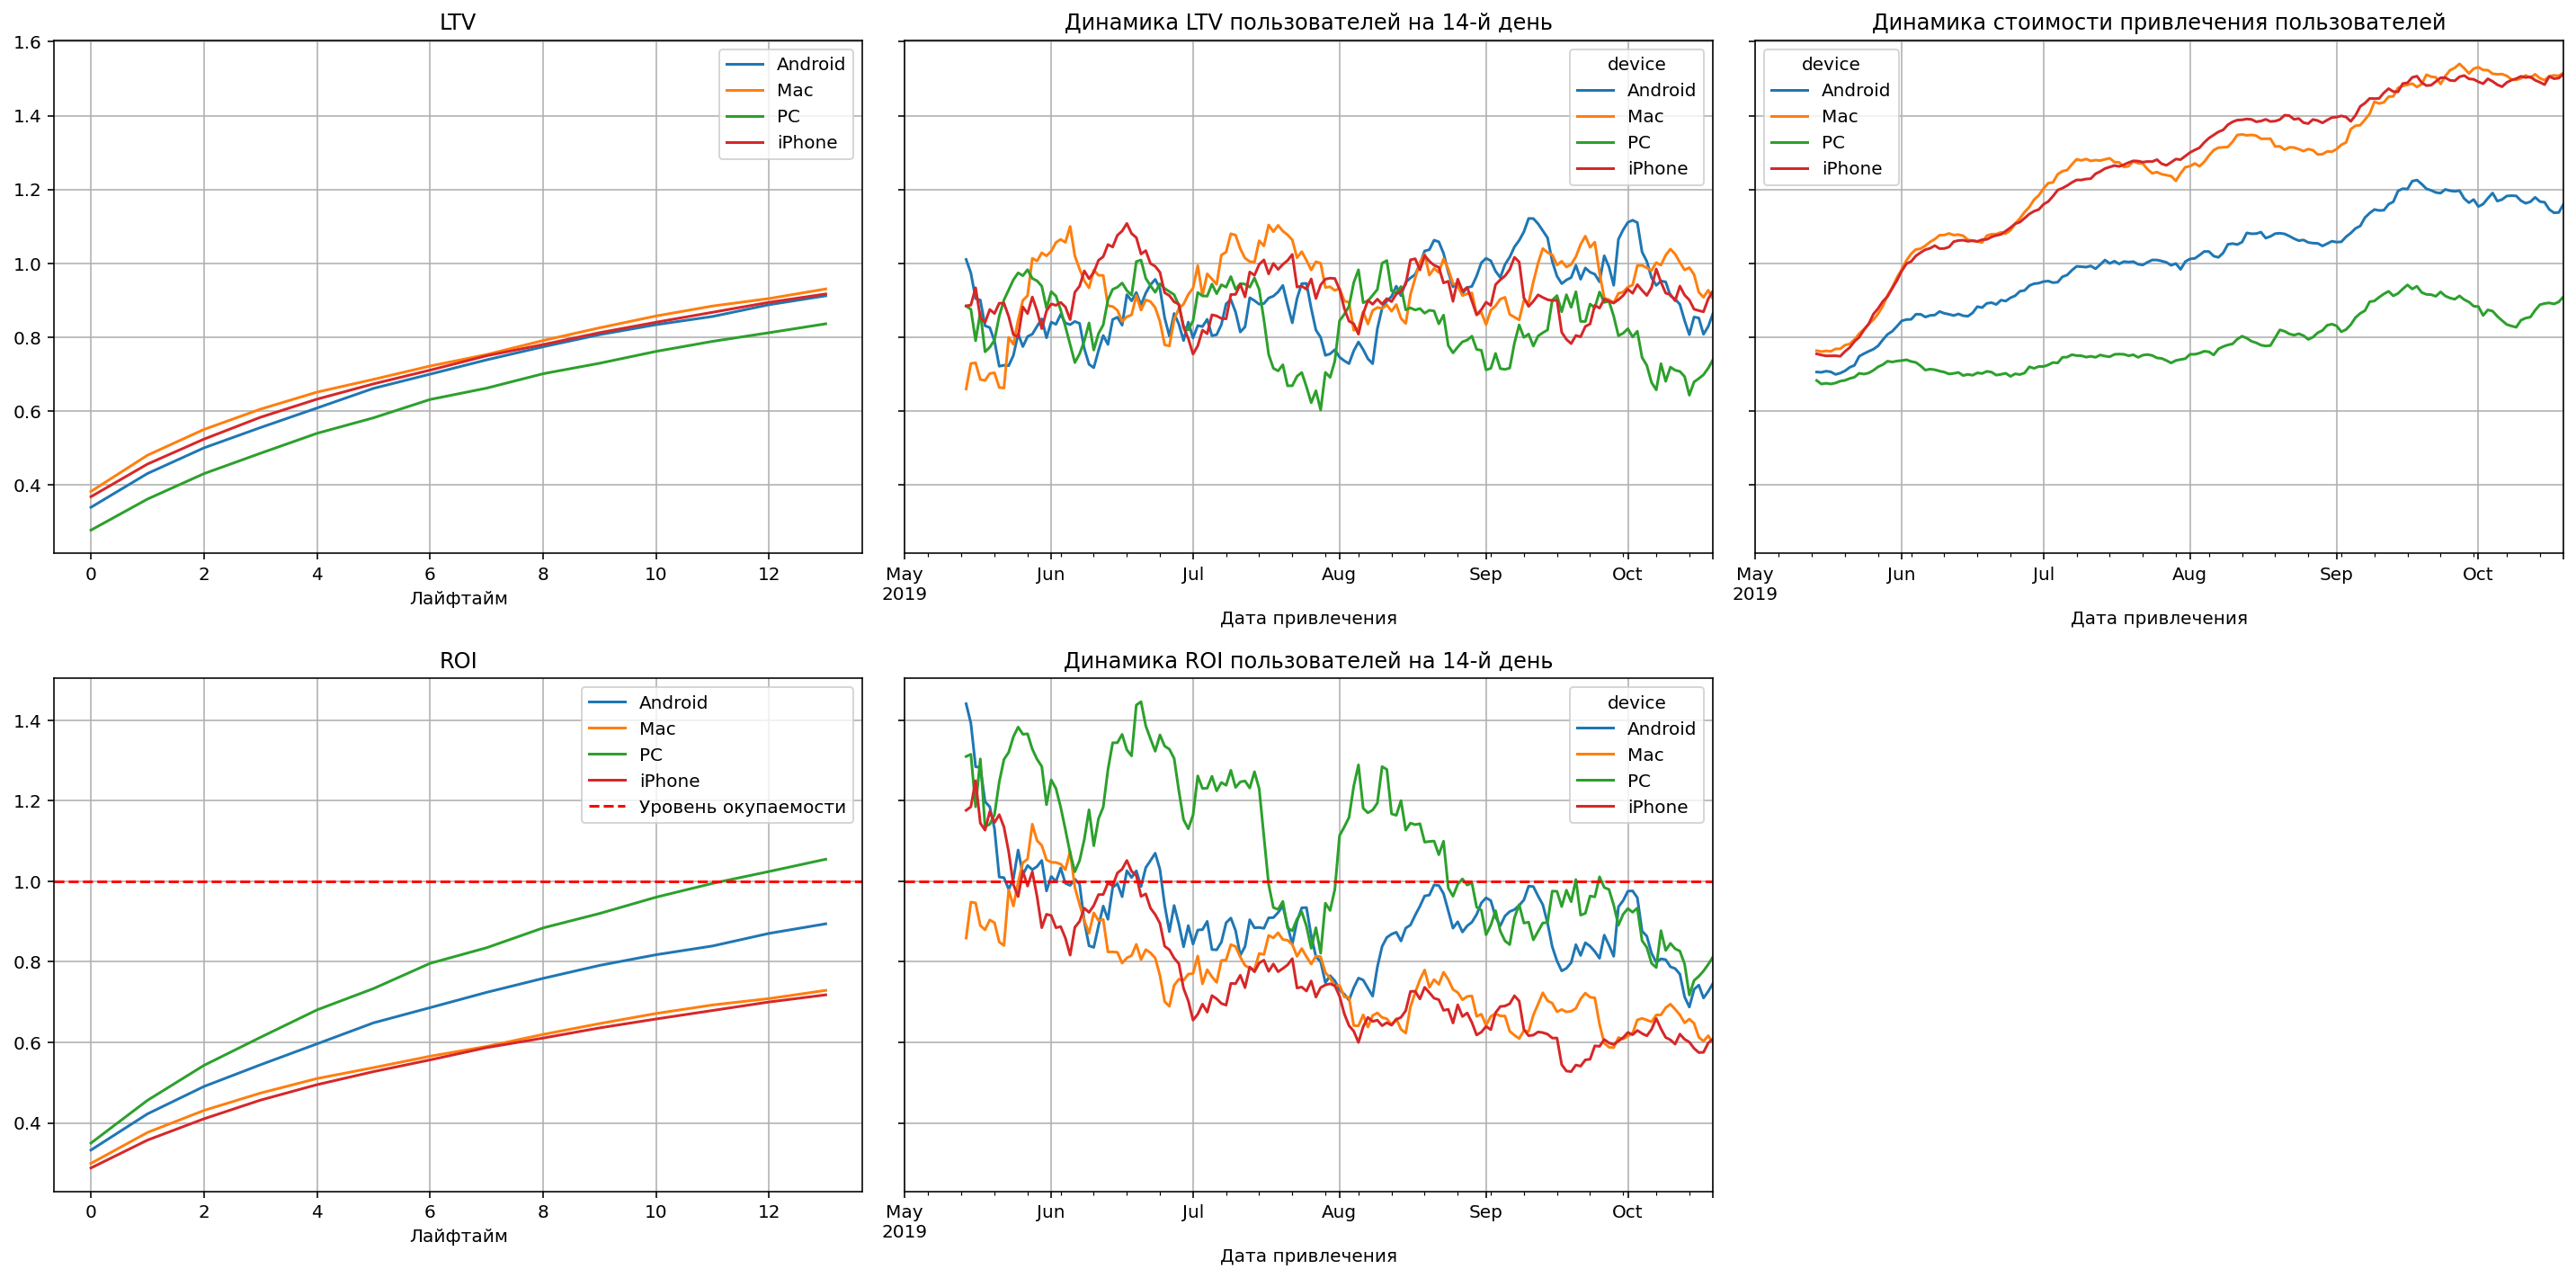

In [32]:
# посмотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Выводы:**
- LTV по устройствам примерно на одном уровне, с небольшим отставанием у РС;
- Стоимость привлечение растет по всем устройставм, с большими темпами по Mac и iPhone;
- Окупаются только пользователи РС;
- В целом окупаемость по всем устройствам снижается в последние 2-3 месяца.

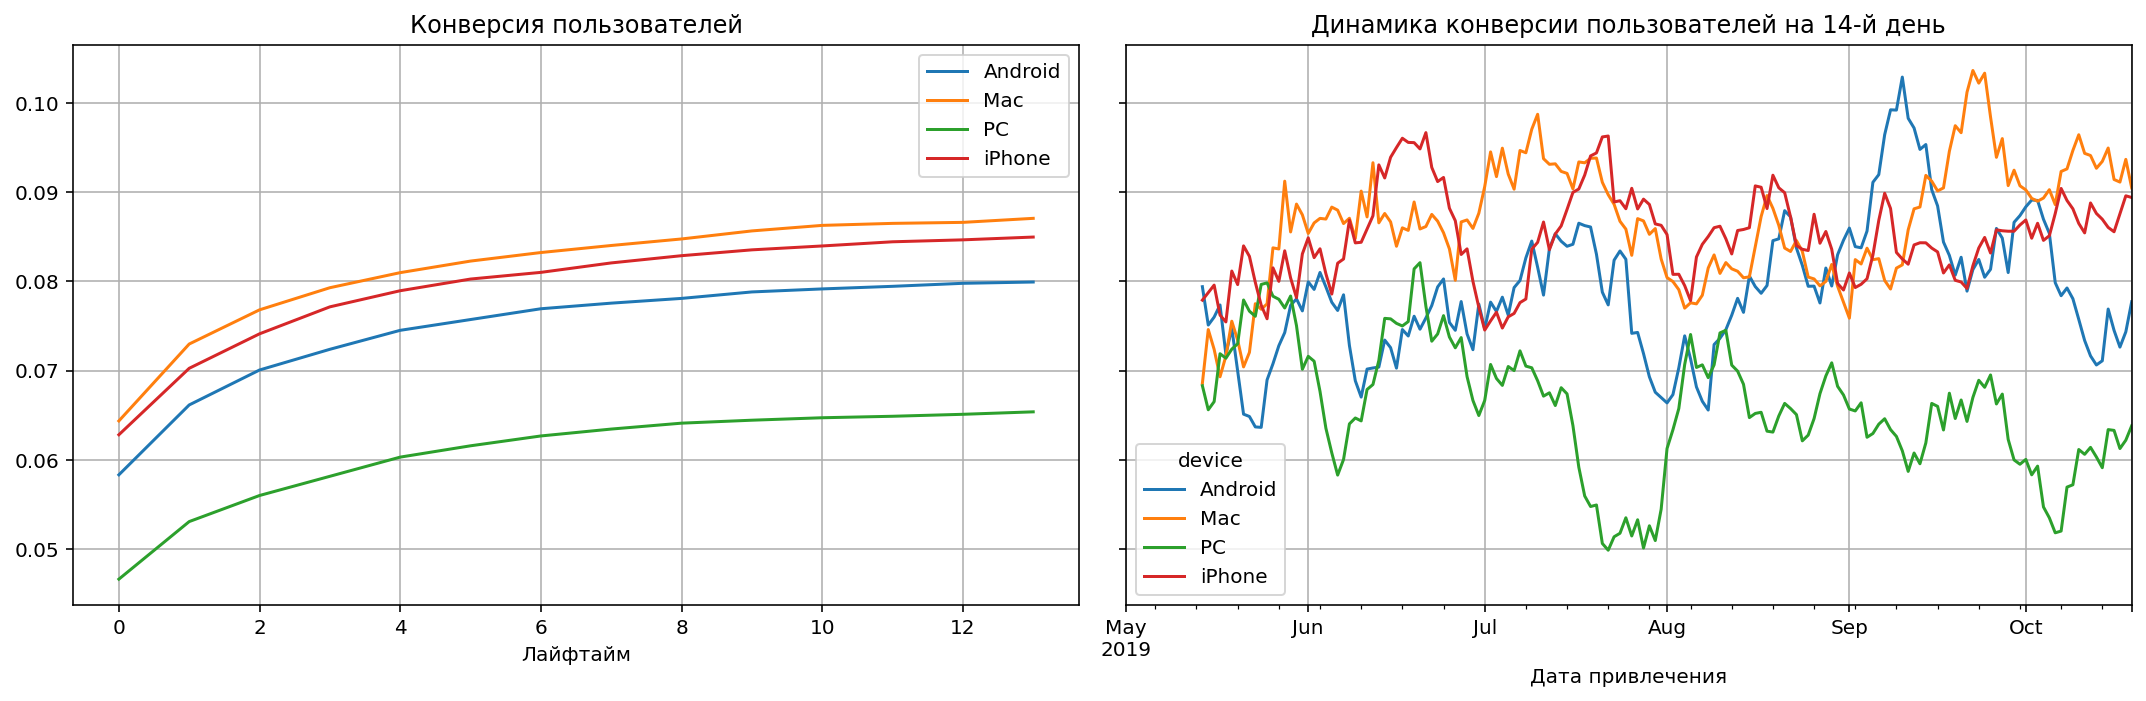

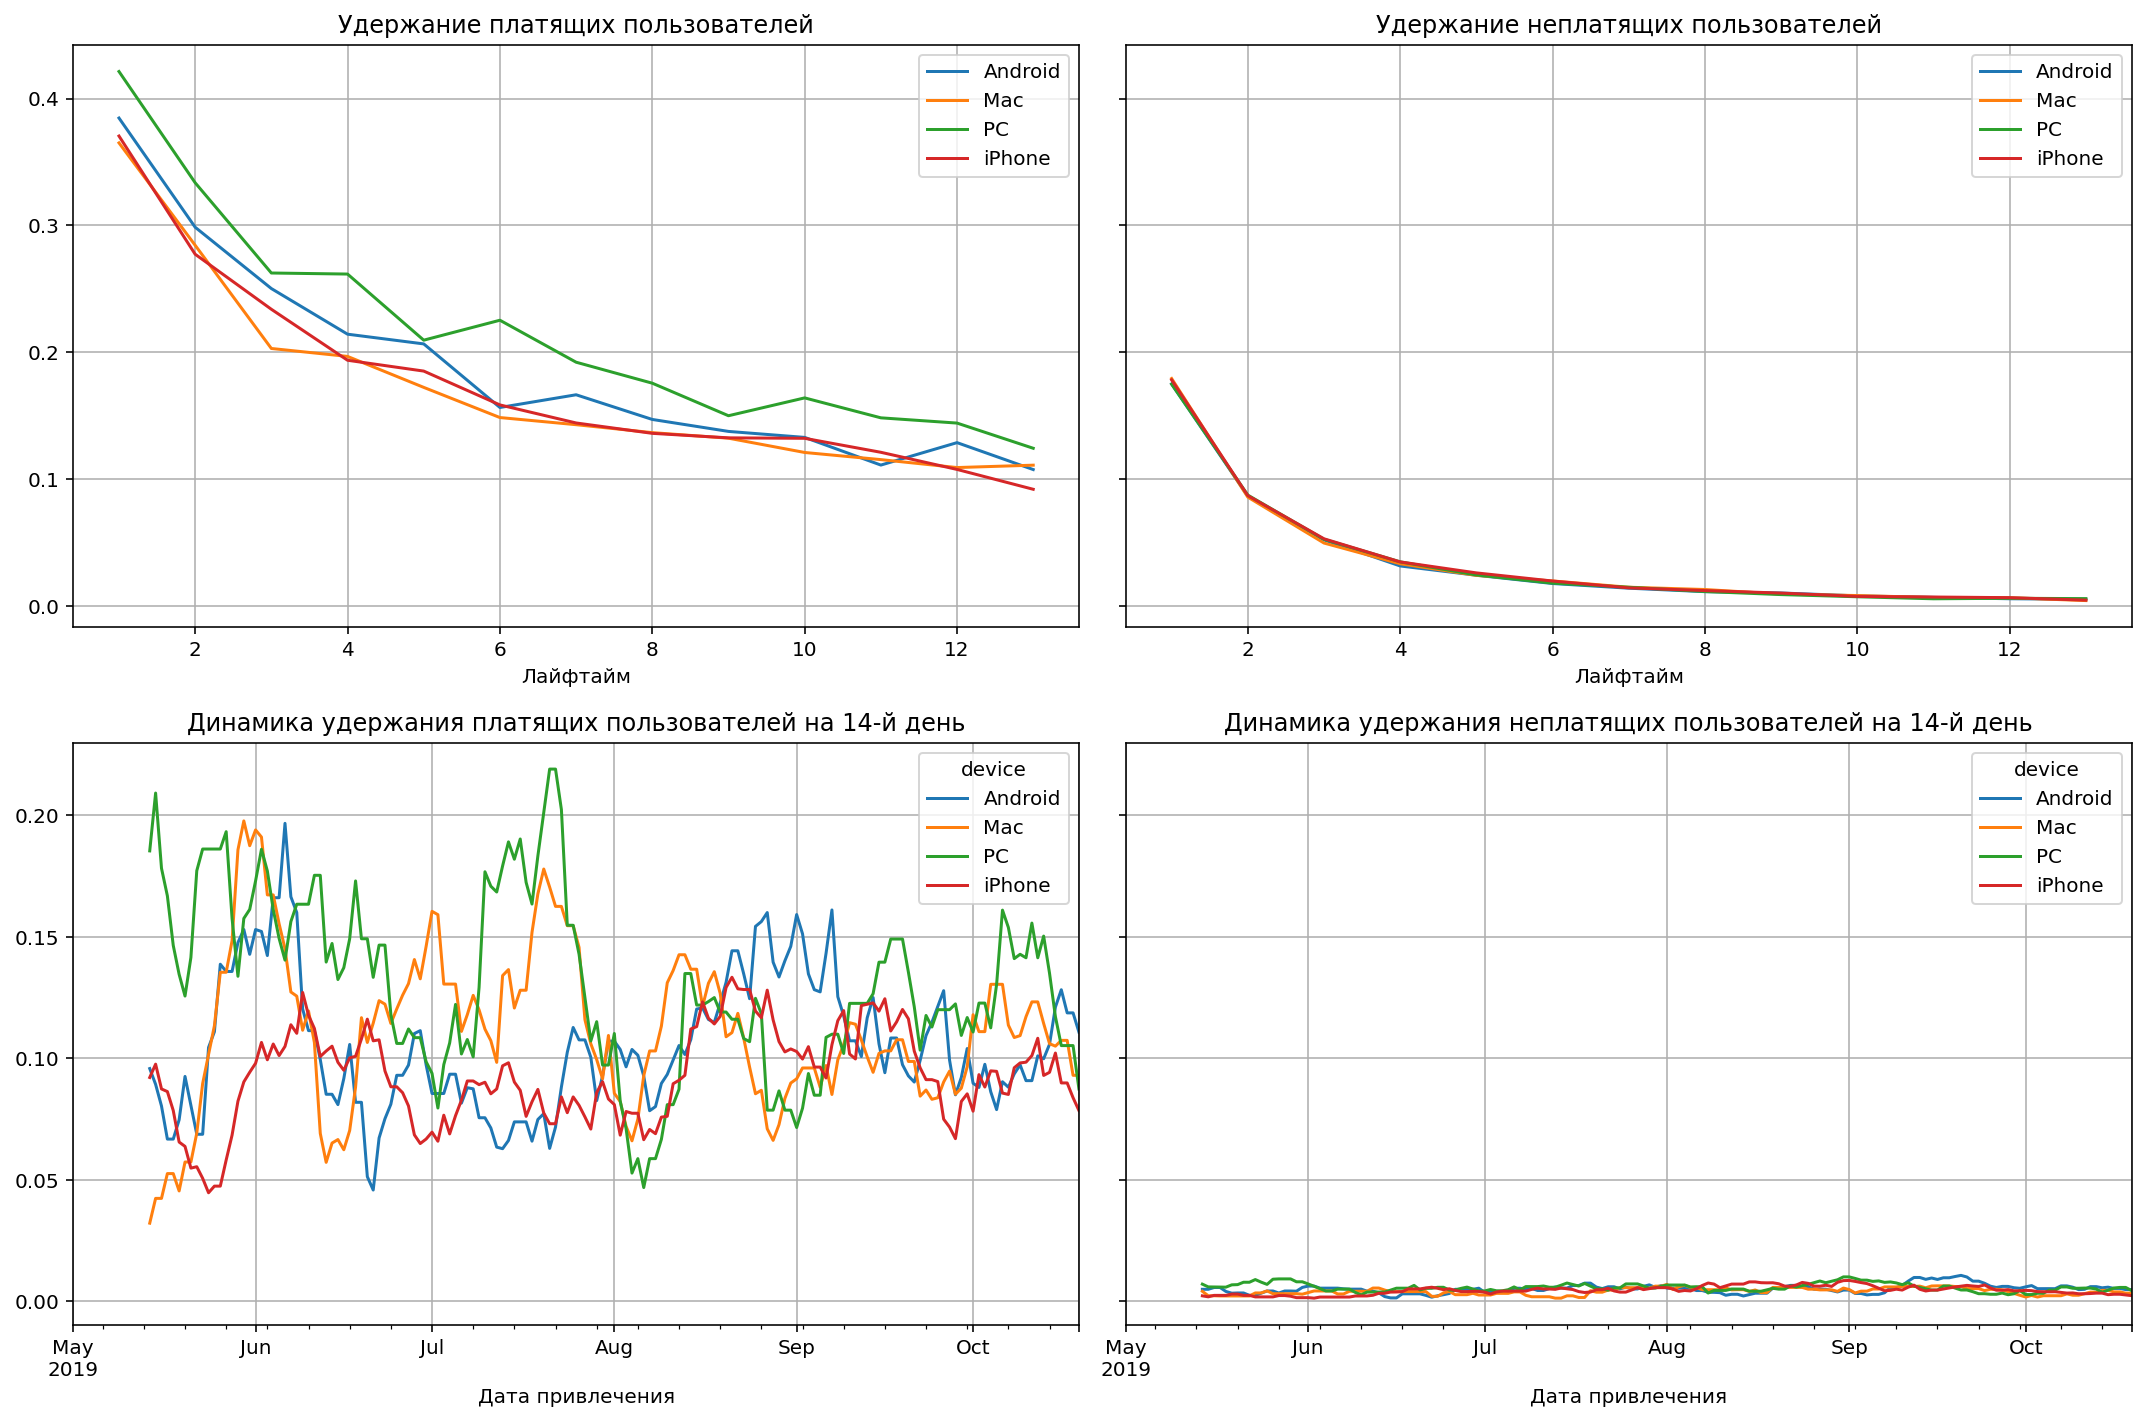

In [33]:
# посмотрим конверсию и удержание с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14)

**Выводы:**
- Конверсия и удержание по устройствам стабильны, находятся примерно на одном уровне;
- У пользователей PC конверсия ниже, но удержание чуть выше.

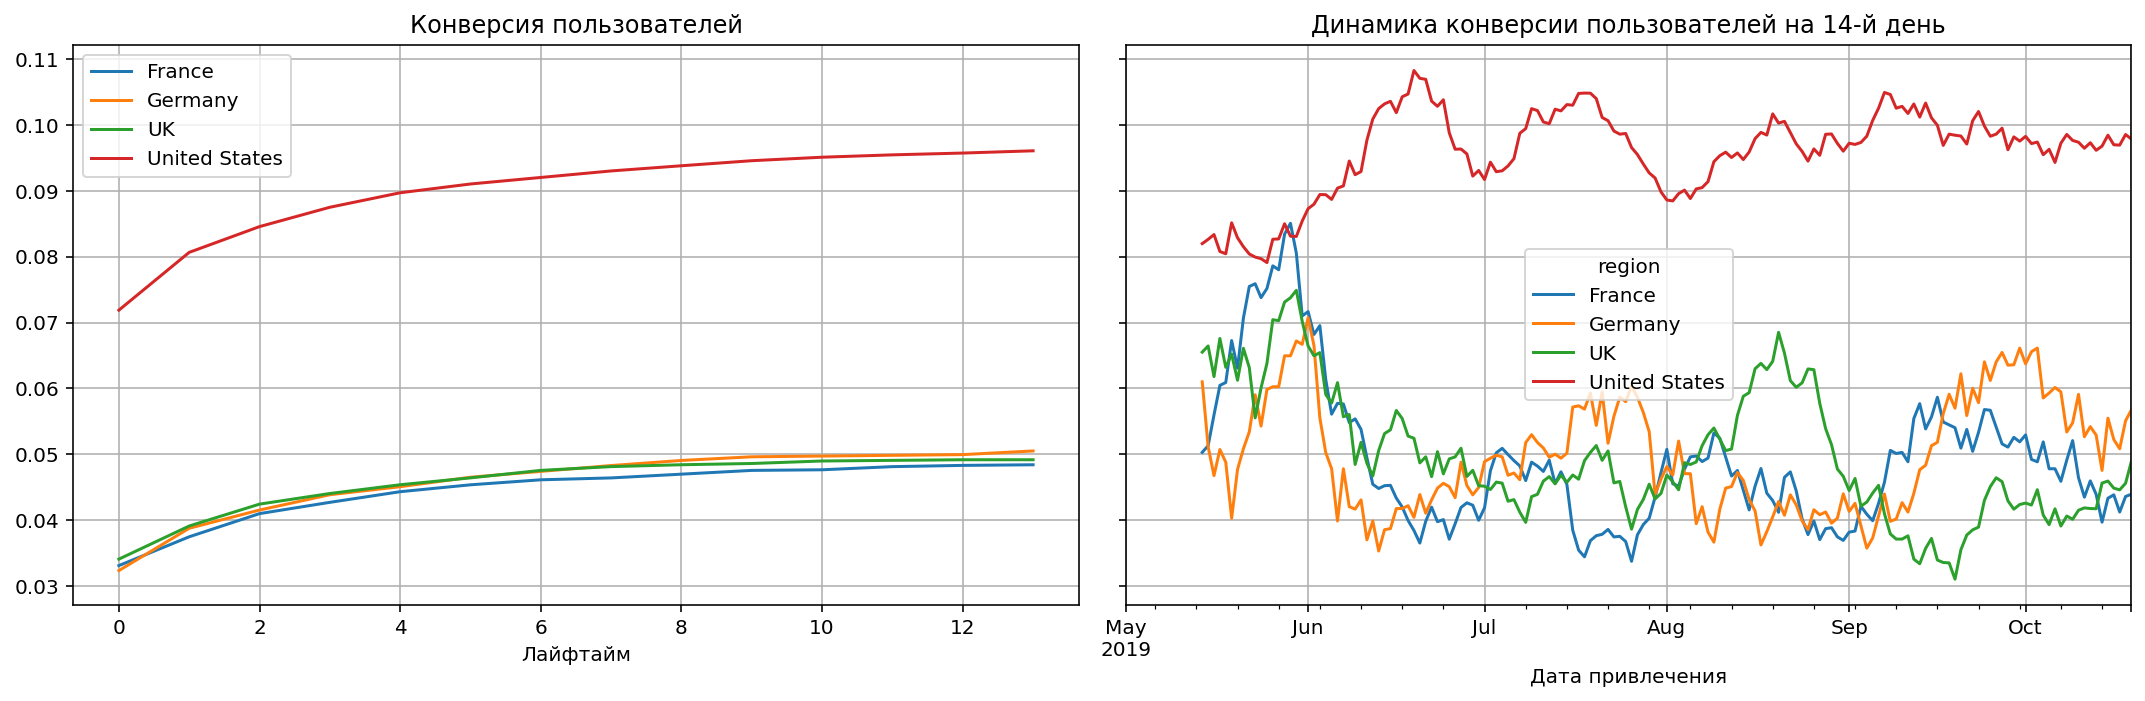

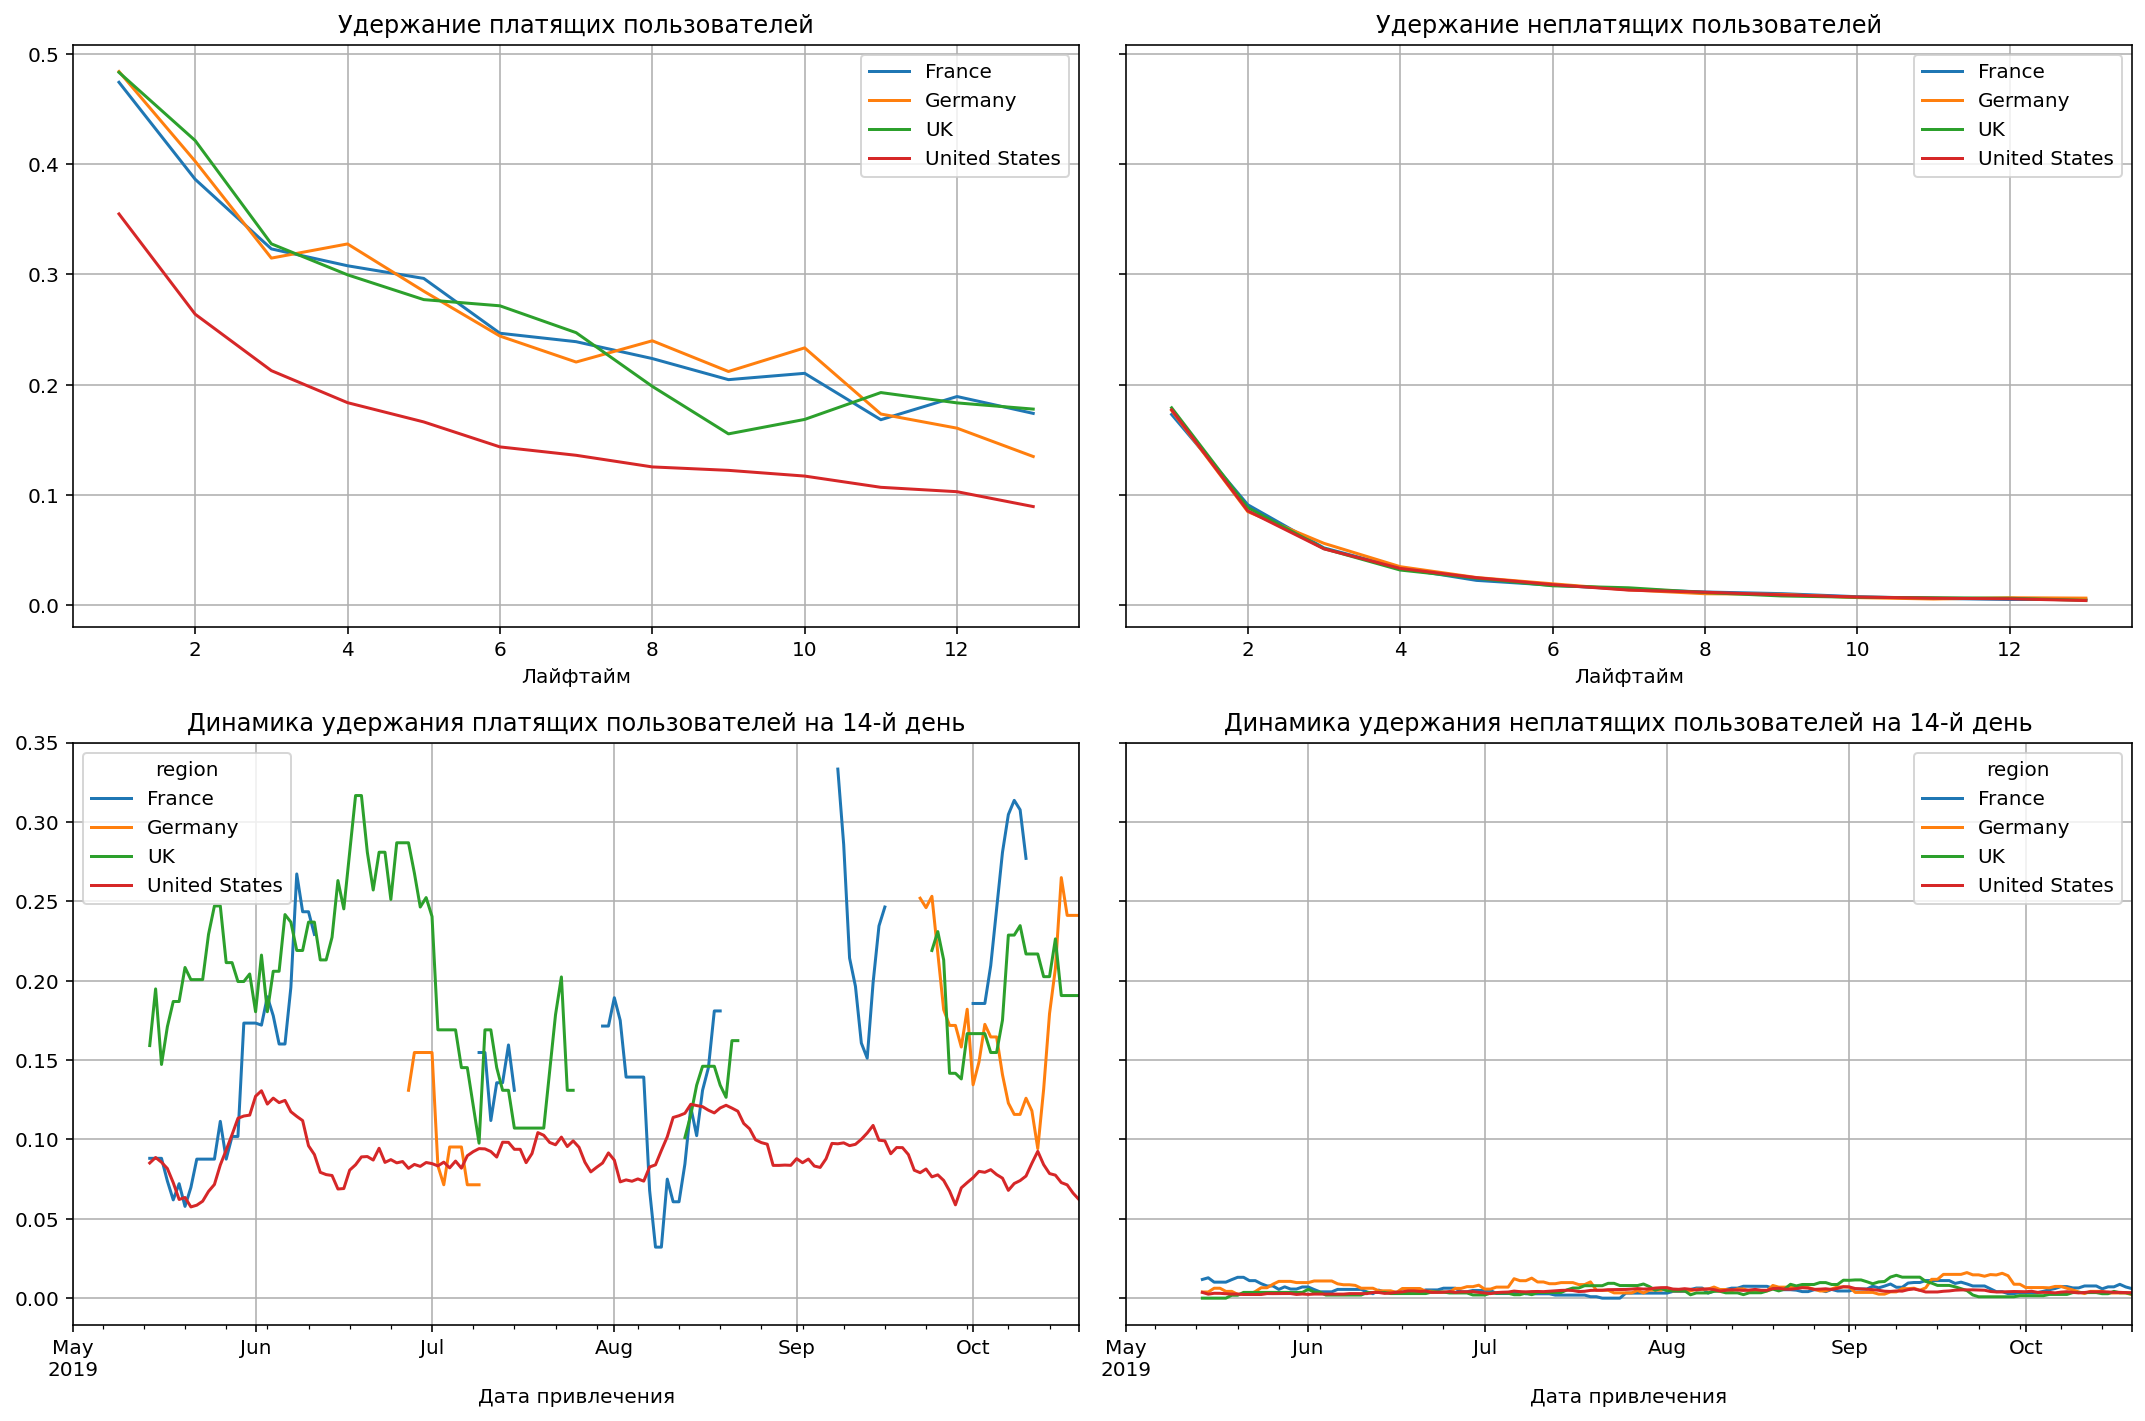

In [34]:
# посмотрим конверсию и удержание с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14)

**Выводы:**
- Пользователи из США стабильно хорошо конвертируются, однако хуже удерживаются.

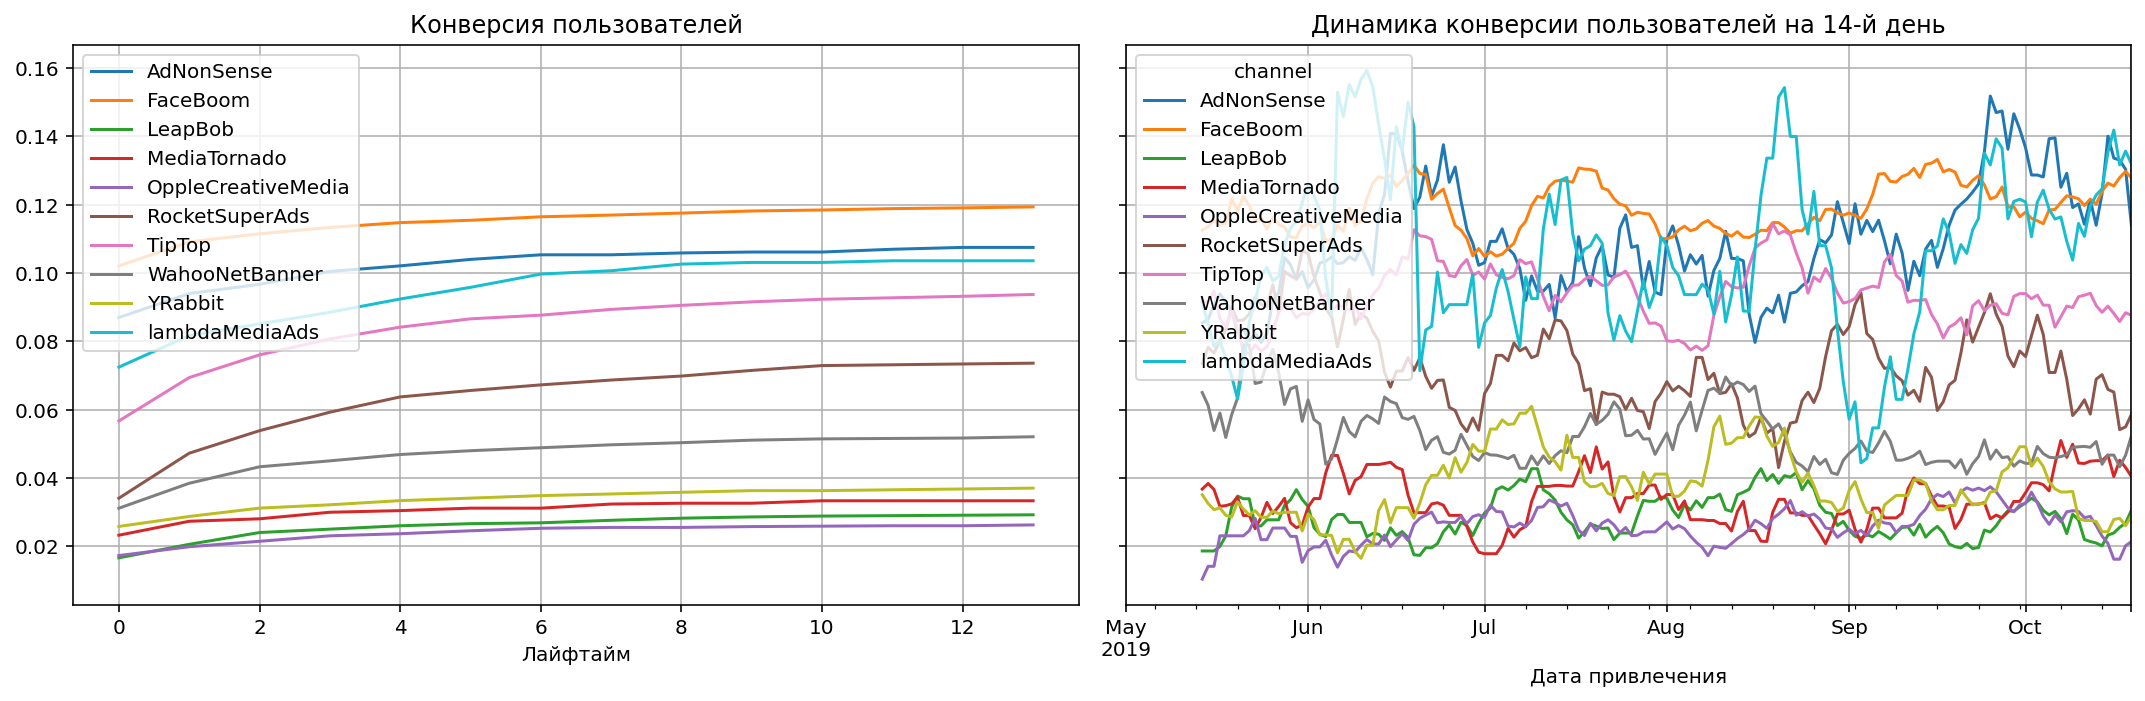

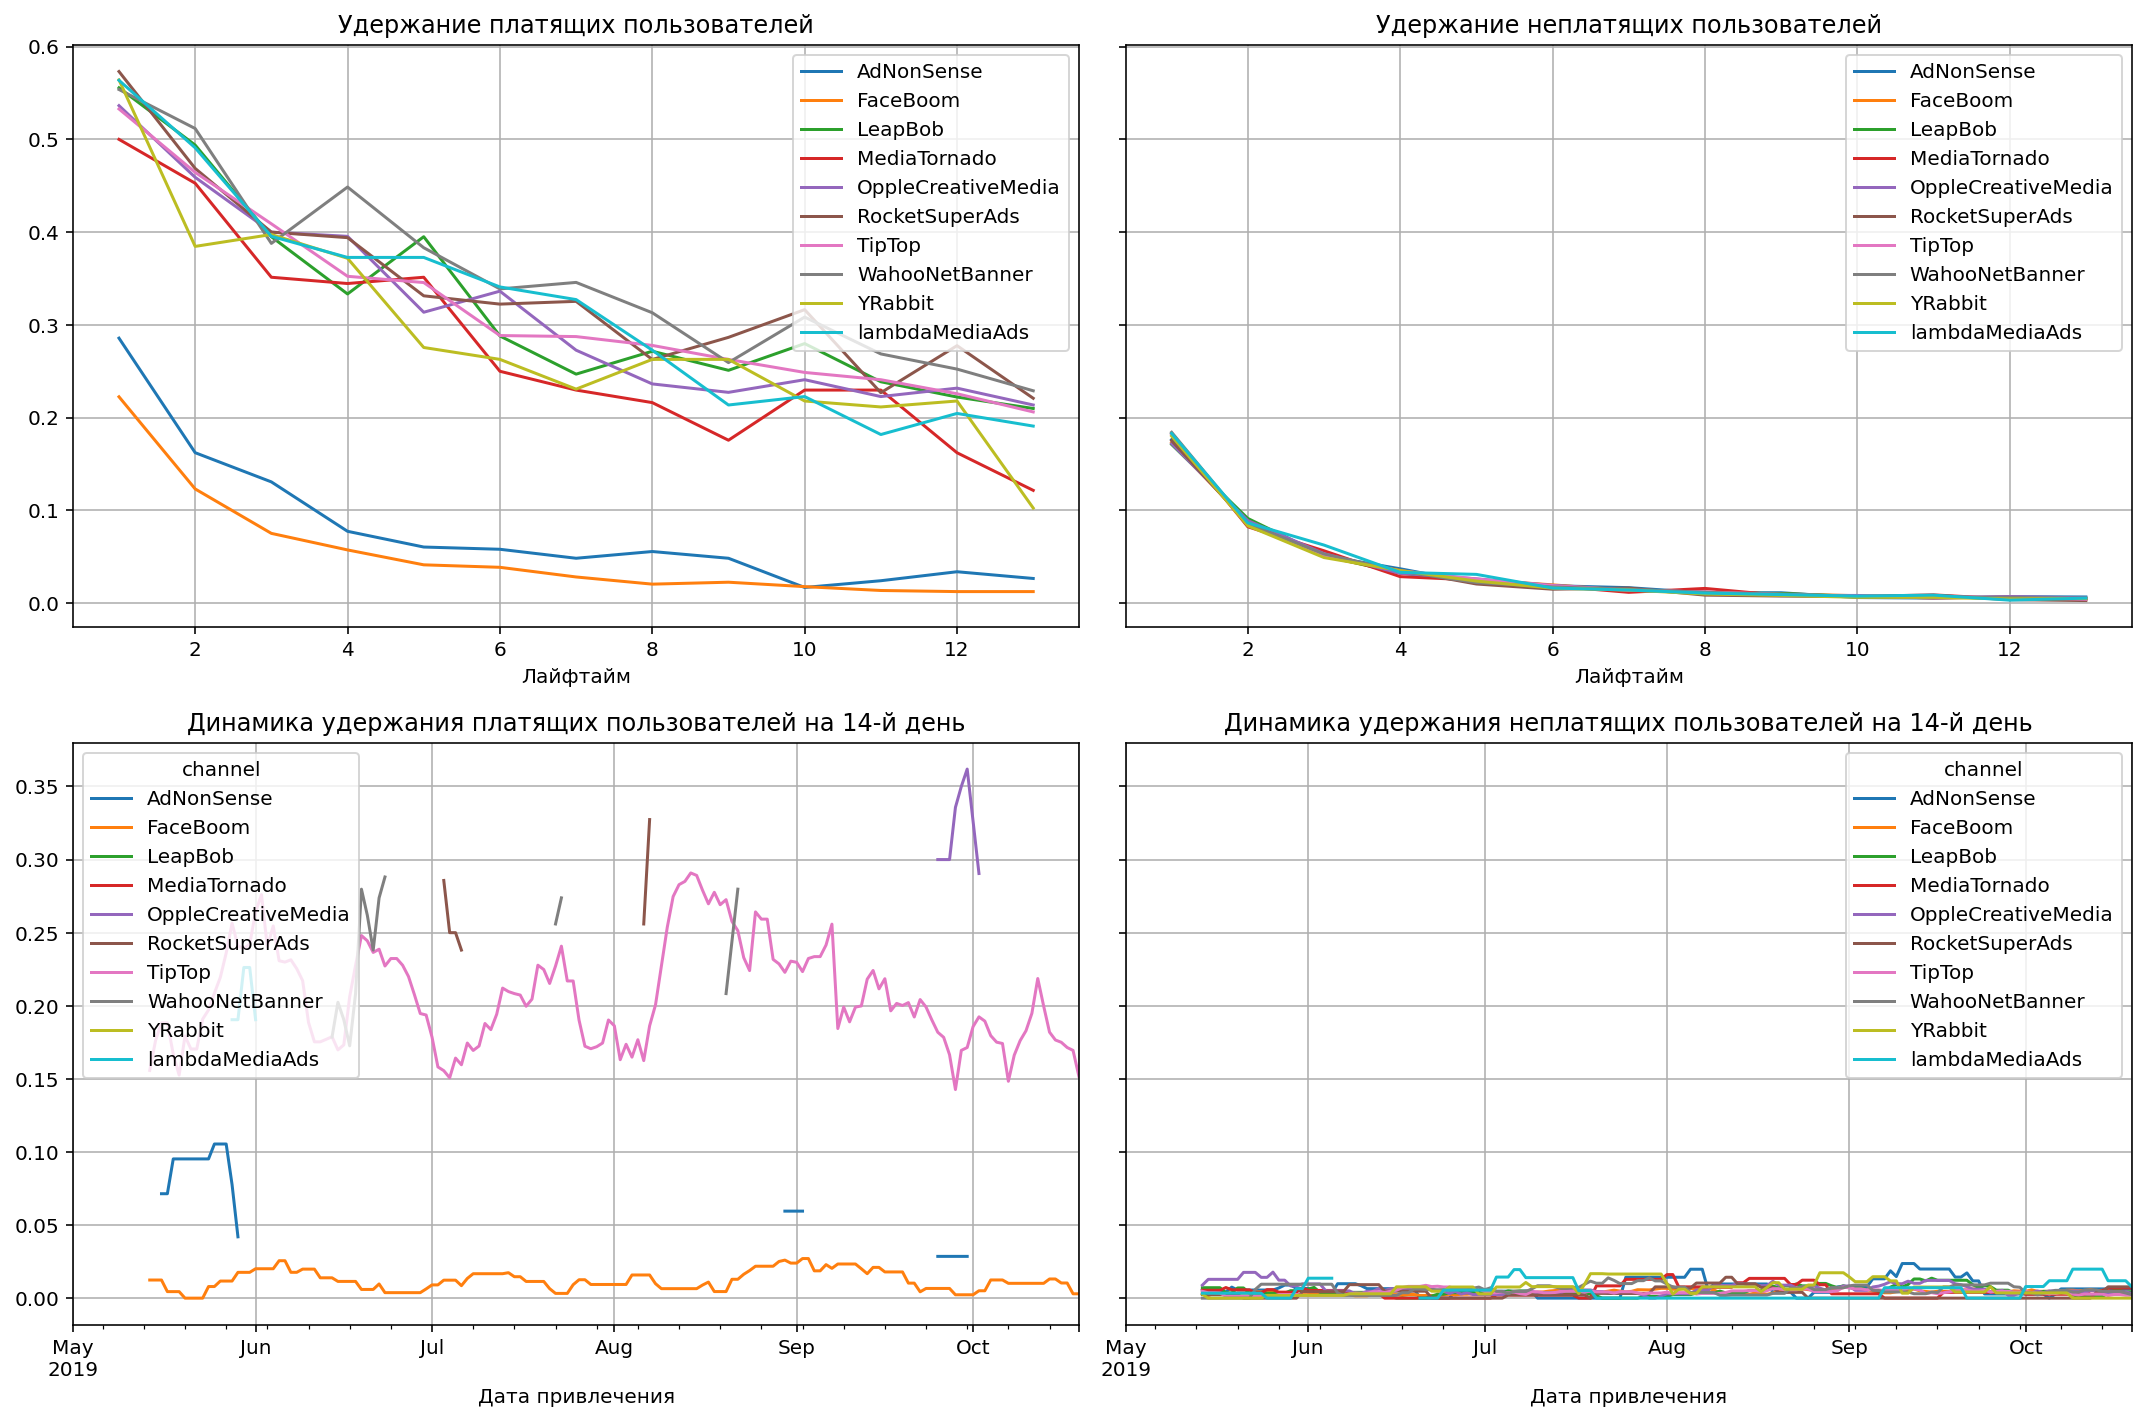

In [35]:
# посмотрим конверсию и удержание с разбивкой по каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=14)

**Выводы:**
- Лучше всех конвертируются пользователи с каналов FaceBoom, AdNonSense, lambdaMediaAds. При этом у FaceBoom и AdNonSense стабильно крайне низкое удержание.

### Общий вывод по окупаемости:
1. В течение 14 дней реклама не окупается - ROI меньше 1;
2. Окупаемость могут снижать следующие факторы:
    - устройства iPhone и Mac;
    - пользователи из США;
    - каналы TipTop, FaceBoom и AdNonSense.
3. Проблемы окупаемости могут быть вызваны:
    - постоянным ростом вложений в источник TipTop;
    - низким удержанием платящих пользователей из США по каналу FaceBoom

## Итоговые выводы
<a id='6'></a>

**Причины неэффективности привлечения пользователей:**
- 3 канала не окупаются: TipTop, FaceBoom и AdNonSense;
- у FaceBoom и AdNonSense крайне низкое удержание;
- Стоимость привлечение по каналу TipTop слишком высокая;
- Отстающая конверсия у пользователей РС.

**Рекомендации:**
- Работать над улучшением удержания пользователей из каналов FaceBoom и AdNonSense;
- Пересмотреть условия сотрудничества с TipTop - уровень конверсии не покрывает высокую стоимость привлечения. Следует сократить вложения в этот канала либо полностью прекратить, направив деньги на развитие более рентабельных каналов из США (MediaTornado, RocketSuperAds);
- Привлекать больше пользователей с канала lambdaMediaAds (один из наиболее перспективных и рентабельных каналов).